# 05_Uncertainty_and_Intervals.ipynb

Uncertainty Quantification and Prediction Intervals for Air Temperature Time Series.

Data source: ../data/surface-air-temperature-monthly-mean-extended.csv

Technologies used: MAPIE, TensorFlow Probability, PyMC3, Uncertainty Toolbox, Pyro, Conformal Prediction (crepes), UQ-Box.

This notebook implements various uncertainty quantification methods for time series forecasting.

In [2]:
# Install required libraries (run this cell first)
import sys
import subprocess

def install_package(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

print("Installing required packages...")
required_packages = [
    "pandas",
    "numpy",
    "matplotlib",
    "scikit-learn",
    "MAPIE",  # for uncertainty estimation
    "tensorflow",
    "tensorflow-probability",
    "pymc>=5.0.0",  # newer version of PyMC
    "arviz",  # for PyMC visualizations
    "seaborn",  # for better plotting
]

for package in required_packages:
    try:
        print(f"Installing {package}...")
        install_package(package)
    except:
        print(f"Could not install {package}. Please install manually if needed.")

print("\nPackage installation complete!")

Installing required packages...
Installing pandas...
Installing numpy...
Installing numpy...
Installing matplotlib...
Installing matplotlib...
Installing scikit-learn...
Installing scikit-learn...
Installing MAPIE...
Installing MAPIE...
Installing tensorflow...
Installing tensorflow...
Installing tensorflow-probability...
Installing tensorflow-probability...
Installing pymc>=5.0.0...
Installing pymc>=5.0.0...
Installing arviz...
Installing arviz...
Installing seaborn...
Installing seaborn...

Package installation complete!

Package installation complete!


In [3]:
# Robust auto-fixer for MAPIE / TF-Probability / PyMC import issues
# - Attempts to import MAPIE classes (with multiple fallbacks)
# - If missing, tries pip upgrade of mapie once
# - If still missing, provides a local shim (MapieRegressorShim / MapieQuantileRegressorShim)
# - Optionally upgrades numpy (if <1.24) and installs pymc/arviz
# - Reports everything clearly
import sys
import subprocess
import importlib
import pkgutil
import inspect
import warnings
from typing import Optional, Tuple
import numpy as np

warnings.filterwarnings("ignore")

PIP = [sys.executable, "-m", "pip", "install", "--upgrade"]

def pip_install(pkg: str):
    try:
        print(f"[pip] Installing/upgrading: {pkg}")
        subprocess.check_call(PIP + [pkg], stdout=subprocess.DEVNULL, stderr=subprocess.STDOUT)
        print(f"[pip] Done: {pkg}")
        return True
    except Exception as e:
        print(f"[pip] FAILED to install {pkg}: {e}")
        return False

def try_import(name: str):
    try:
        mod = importlib.import_module(name)
        return mod
    except Exception as e:
        return None

# ---------- 1) MAPIE: try robust imports, fallback to shim if needed ----------
mapie = try_import("mapie")
MapieRegressor = None
MapieQuantileRegressor = None

def dynamic_mapie_search():
    global mapie, MapieRegressor, MapieQuantileRegressor
    if mapie:
        print("[INFO] found 'mapie' package, version:", getattr(mapie, "__version__", "unknown"))
    else:
        print("[WARN] 'mapie' not installed. Attempting to pip install mapie.")
        if pip_install("mapie"):
            mapie = try_import("mapie")

    if not mapie:
        print("[ERROR] mapie still not importable. Will provide a local shim.")
        return False

    # Search for classes with likely names in submodules
    candidates = []
    # walk available submodules inside mapie
    try:
        pkgpath = mapie.__path__
        for finder, name, ispkg in pkgutil.walk_packages(pkgpath, prefix="mapie."):
            candidates.append(name)
    except Exception:
        # fallback to trying common modules
        candidates = [
            "mapie.regression", "mapie.regression.regression", "mapie.regression._regression",
            "mapie.quantile_regression", "mapie.quantile_regression.quantile_regression"
        ]

    found = False
    for modname in candidates:
        try:
            mod = importlib.import_module(modname)
        except Exception:
            continue
        for objname, obj in inspect.getmembers(mod, inspect.isclass):
            # pick names that look like Mapie/Regressor/Quantile/reg
            lname = objname.lower()
            if "mapie" in lname and "regress" in lname:
                MapieRegressor = obj
                found = True
                print(f"[OK] Found MapieRegressor as {modname}.{objname}")
            if "mapie" in lname and "quantile" in lname:
                MapieQuantileRegressor = obj
                found = True
                print(f"[OK] Found MapieQuantileRegressor as {modname}.{objname}")
            # more generic pattern: any class name ending with 'Regressor' that has fit/predict
            if objname.endswith("Regressor") and hasattr(obj, "fit") and hasattr(obj, "predict"):
                if MapieRegressor is None:
                    MapieRegressor = obj
                    found = True
                    print(f"[OK] Using {modname}.{objname} as MapieRegressor fallback")
    if not found:
        print("[WARN] Could not detect MapieRegressor/MapieQuantileRegressor in installed MAPIE.")
    return found

_has_mapie_classes = dynamic_mapie_search()

# If MAPIE doesn't provide expected classes, create a shim to mimic minimal behavior
if not _has_mapie_classes:
    print("[INFO] Creating local Mapie shims (MapieRegressorShim and MapieQuantileRegressorShim).")

    from sklearn.model_selection import train_test_split
    from sklearn.base import clone
    from numpy import quantile

    class MapieRegressorShim:
        """
        Minimal shim to mimic MapieRegressor behavior:
        - init(estimator)
        - fit(X, y, **kwargs) -> splits calibration set and fits estimator + stores residuals
        - predict(X, alpha=[0.05]) -> returns predictions and intervals (lower, upper)
        NOTE: This shim uses a single holdout calibration split (not cross-validation).
        """
        def __init__(self, estimator, cv="split", agg_function=None):
            self.base_estimator = estimator
            self.cv = cv
            self.agg_function = agg_function
            self.is_fitted = False

        def fit(self, X, y, *, calibration_fraction=0.2, random_state=0):
            X = np.asarray(X)
            y = np.asarray(y).reshape(-1)
            if calibration_fraction <= 0 or calibration_fraction >= 1.0:
                raise ValueError("calibration_fraction must be in (0,1)")
            X_tr, X_cal, y_tr, y_cal = train_test_split(X, y, test_size=calibration_fraction, random_state=random_state, shuffle=False)
            self.estimator_ = clone(self.base_estimator)
            self.estimator_.fit(X_tr, y_tr)
            self.y_pred_cal_ = self.estimator_.predict(X_cal).reshape(-1)
            self.residuals_ = np.abs(y_cal - self.y_pred_cal_)
            self.calibration_X_ = X_cal
            self.is_fitted = True
            return self

        def predict(self, X, *, alpha=0.05, return_pred=False):
            """
            Returns:
               y_pred : (n,)
               y_pis : (n, 2) lower, upper
            """
            if not self.is_fitted:
                raise RuntimeError("MapieRegressorShim not fitted. Call fit() first.")
            X = np.asarray(X)
            y_pred = self.estimator_.predict(X).reshape(-1)
            # simple symmetric interval: quantile of residuals
            q = np.quantile(self.residuals_, 1 - alpha)
            lower = y_pred - q
            upper = y_pred + q
            y_pis = np.vstack([lower, upper]).T
            if return_pred:
                return y_pred, y_pis
            return y_pis

        # compatibility helper used in some example notebooks
        def predict_with_interval(self, X, alpha=0.05):
            yp, pis = self.predict(X, alpha=alpha, return_pred=True)
            return yp, pis

    class MapieQuantileRegressorShim(MapieRegressorShim):
        """Shim that keeps same interface (but uses residual quantile like above)."""
        pass

    # Bind shims to names expected downstream
    MapieRegressor = MapieRegressorShim
    MapieQuantileRegressor = MapieQuantileRegressorShim
    print("[OK] Local MAPIE shim created. It uses a single calibration holdout and residual quantiles for intervals.")
else:
    print("[OK] Using installed MAPIE classes.")

# ---------- 2) TensorFlow Probability ----------
tf = try_import("tensorflow")
tfp = try_import("tensorflow_probability")
if tf is None:
    print("[WARN] TensorFlow not present. If you need TF, install with: pip install tensorflow")
else:
    print("[OK] TensorFlow version:", tf.__version__)
    if tfp is None:
        print("[WARN] tensorflow_probability not installed. Attempting to pip install tensorflow-probability.")
        pip_install("tensorflow-probability")
        tfp = try_import("tensorflow_probability")
        if tfp is None:
            print("[ERROR] tensorflow_probability still missing after install attempt.")
        else:
            print("[OK] tensorflow_probability version:", getattr(tfp, "__version__", "unknown"))
    else:
        print("[OK] tensorflow_probability version:", getattr(tfp, "__version__", "unknown"))

# ---------- 3) PyMC + numpy compatibility ----------
pm = try_import("pymc")
az = try_import("arviz")
np_ver = tuple(map(int, np.__version__.split(".")[:2]))
if pm is None or az is None:
    print("[INFO] PyMC / ArviZ not available or incompatible.")
    print("[INFO] Detected NumPy version:", np.__version__)
    if np_ver < (1, 24):
        print("[ACTION] NumPy < 1.24 detected. Attempting to upgrade numpy to >=1.24 (this can be disruptive).")
        # attempt upgrade - may need restart of kernel
        success = pip_install("numpy>=1.24,<2")
        if success:
            print("[ACTION] After numpy upgrade, reinstalling pymc and arviz (best-effort).")
            pip_install("pymc")
            pip_install("arviz")
            # try to re-import
            try:
                import importlib
                importlib.invalidate_caches()
                pm = try_import("pymc")
                az = try_import("arviz")
            except Exception:
                pm = None
                az = None
        else:
            print("[ERROR] Failed to upgrade numpy automatically.")
    else:
        print("[INFO] NumPy version looks OK for PyMC, attempting to install PyMC/ArviZ anyway.")
        pip_install("pymc")
        pip_install("arviz")
        pm = try_import("pymc")
        az = try_import("arviz")

if pm is not None and az is not None:
    print("[OK] PyMC and ArviZ available:", getattr(pm, "__version__", "unknown"), getattr(az, "__version__", "unknown"))
else:
    print("[WARN] PyMC/ArviZ not available. If you require them, consider manually running:")
    print("   pip install --upgrade numpy pymc arviz")
    print("Then restart your kernel to apply binary changes.")

# ---------- 4) Final summary ----------
print("\n===== FINAL SUMMARY =====")
print("MAPIE package present:", "YES" if mapie is not None else "NO")
print("MapieRegressor available:", "YES" if MapieRegressor is not None else "NO (shim used)" if mapie is None else "NO (mapie installed but classes not found)")
print("MapieQuantileRegressor available:", "YES" if MapieQuantileRegressor is not None else "NO")
print("TensorFlow present:", "YES" if tf is not None else "NO")
print("TensorFlow Probability present:", "YES" if tfp is not None else "NO")
print("PyMC present:", "YES" if pm is not None else "NO")
print("ArviZ present:", "YES" if az is not None else "NO")
print("NumPy version:", np.__version__)

print("\nNotes:")
print("- If numpy was upgraded in this run, you should RESTART the kernel and re-run notebook cells that import compiled modules (scipy, sklearn, pymc, tensorflow).")
print("- If you see 'shim' messages for MapieRegressor, the shim implements a simple holdout-based conformal interval method and will let existing code using MapieRegressor.run roughly continue.")
print("- If you want me to attempt a safer, interactive sequence (confirm each upgrade before running), tell me and I'll deliver that cell instead.")


[INFO] found 'mapie' package, version: 1.0.1
[OK] Using mapie.conformity_scores.regression.EnsembleRegressor as MapieRegressor fallback
[OK] Found MapieRegressor as mapie.regression.quantile_regression._MapieQuantileRegressor
[OK] Found MapieQuantileRegressor as mapie.regression.quantile_regression._MapieQuantileRegressor
[OK] Found MapieRegressor as mapie.regression.quantile_regression._MapieRegressor
[OK] Found MapieRegressor as mapie.regression.regression._MapieRegressor
[OK] Found MapieRegressor as mapie.regression.time_series_regression._MapieRegressor
[OK] Using installed MAPIE classes.


WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install gxx`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.


[OK] TensorFlow version: 2.12.0
[OK] tensorflow_probability version: 0.20.1
[OK] PyMC and ArviZ available: 5.25.1 0.22.0

===== FINAL SUMMARY =====
MAPIE package present: YES
MapieRegressor available: YES
MapieQuantileRegressor available: YES
TensorFlow present: YES
TensorFlow Probability present: YES
PyMC present: YES
ArviZ present: YES
NumPy version: 1.26.4

Notes:
- If numpy was upgraded in this run, you should RESTART the kernel and re-run notebook cells that import compiled modules (scipy, sklearn, pymc, tensorflow).
- If you see 'shim' messages for MapieRegressor, the shim implements a simple holdout-based conformal interval method and will let existing code using MapieRegressor.run roughly continue.
- If you want me to attempt a safer, interactive sequence (confirm each upgrade before running), tell me and I'll deliver that cell instead.
[OK] PyMC and ArviZ available: 5.25.1 0.22.0

===== FINAL SUMMARY =====
MAPIE package present: YES
MapieRegressor available: YES
MapieQuantileR

In [4]:
# Robust data load + lag creation + safe time-ordered split (no more ValueError)
import os
import pandas as pd
import numpy as np
from pandas.tseries.offsets import DateOffset

CSV_PATH = '../data/surface-air-temperature-monthly-mean-extended.csv'  # adjust if needed
DATE_COL_CANDIDATES = ['month', 'date', 'Month', 'Date']
TARGET_CANDIDATES = ['mean_temp', 'mean temperature', 'temperature', 'temp', 't']

def find_column(df, candidates):
    for c in candidates:
        for col in df.columns:
            if col.lower() == c.lower():
                return col
    return None

def add_rows_by_repeating_last(df, n_to_add):
    """Duplicate last row n_to_add times, advancing the DatetimeIndex by months when possible."""
    if n_to_add <= 0:
        return df
    last_row = df.iloc[-1:].copy()
    new_rows = []
    last_index = df.index[-1]
    for i in range(1, n_to_add+1):
        new_idx = None
        if isinstance(last_index, pd.Timestamp):
            # add months if datetime index
            new_idx = last_index + DateOffset(months=i)
        elif isinstance(last_index, (int, np.integer)):
            new_idx = last_index + i
        else:
            # fallback: use integer positions as new index
            new_idx = len(df) + i - 1
        r = last_row.copy()
        r.index = [new_idx]
        new_rows.append(r)
    return pd.concat([df] + new_rows)

# 1) load
if not os.path.exists(CSV_PATH):
    raise FileNotFoundError(f"CSV not found at {CSV_PATH}. Fix path or place file there.")

raw = pd.read_csv(CSV_PATH)
if raw.shape[0] == 0:
    raise ValueError("CSV is empty (0 rows). Provide data.")

print("Loaded CSV shape:", raw.shape)
print("Columns:", list(raw.columns)[:50])

# 2) detect date column
date_col = find_column(raw, DATE_COL_CANDIDATES)
if date_col is None:
    # try first column if parseable
    try:
        pd.to_datetime(raw.iloc[:, 0])
        date_col = raw.columns[0]
        print(f"[INFO] Using first column '{date_col}' as date.")
    except Exception:
        raise ValueError("Could not detect a date column. Rename the date column to 'month' or 'date' or pass a file with a parsable first column.")

raw[date_col] = pd.to_datetime(raw[date_col], errors='coerce')
df = raw.set_index(date_col).sort_index()
if df.index.isnull().any():
    before = df.shape[0]
    df = df[~df.index.isnull()]
    print(f"[WARN] Dropped {before - df.shape[0]} rows with unparseable dates.")

if df.shape[0] == 0:
    raise ValueError("No rows remain after parsing dates.")

# 3) detect target
target_col = find_column(df, TARGET_CANDIDATES)
if target_col is None:
    print("Available columns:", df.columns.tolist())
    raise ValueError("Could not find target column (mean_temp). Rename target or update TARGET_CANDIDATES list.")
print(f"[INFO] Using target column: '{target_col}'")

# 4) basic seasonal features
df = df.copy()
df['month_sin'] = np.sin(2 * np.pi * df.index.month / 12)
df['month_cos'] = np.cos(2 * np.pi * df.index.month / 12)

# 5) create lag columns (create even if they produce NaN)
df['lag_1'] = df[target_col].shift(1)
df['lag_12'] = df[target_col].shift(12)

# 6) If after creating lags there are many NaNs, impute thoughtfully:
# Strategy: keep target rows, but impute lag columns using forward-fill -> back-fill -> column median.
lag_cols = ['lag_1', 'lag_12']
for col in lag_cols:
    if col in df.columns:
        n_before = df[col].isna().sum()
        # try forward/backfill
        df[col] = df[col].fillna(method='ffill').fillna(method='bfill')
        # if still NaN (e.g., all values NaN), fill with target median
        if df[col].isna().all():
            med = df[target_col].median()
            df[col] = df[target_col].apply(lambda _: med)
            print(f"[FALLBACK] {col} was all NaN -> filled with target median {med:.4f}")
        else:
            # if some NaNs remain, fill them with median of non-NaN lag values, else target median
            if df[col].isna().any():
                non_na_med = df[col].median()
                if np.isnan(non_na_med):
                    non_na_med = df[target_col].median()
                df[col] = df[col].fillna(non_na_med)
        n_after = df[col].isna().sum()
        if n_before > 0:
            print(f"[IMPUTE] {col}: filled {n_before - n_after} NaNs (ffill/bfill/median fallback).")

# 7) drop rows where target itself is NaN (we can't use them)
n_rows_before = df.shape[0]
df = df.dropna(subset=[target_col])
n_rows_after = df.shape[0]
if n_rows_after < n_rows_before:
    print(f"[WARN] Dropped {n_rows_before - n_rows_after} rows because target was NaN.")

# 8) ensure minimal dataset length: need at least 2 rows for train/test split
MIN_ROWS = 2
if len(df) < MIN_ROWS:
    to_add = MIN_ROWS - len(df)
    df = add_rows_by_repeating_last(df, to_add)
    print(f"[AUTO] Dataset too small. Duplicated last row {to_add} time(s) to reach {len(df)} rows.")

# 9) final check: if still zero, stop (shouldn't happen)
if len(df) == 0:
    raise ValueError("No usable data after preprocessing. Provide more rows.")

# 10) build features & target
chosen_features = ['month_sin', 'month_cos'] + [c for c in lag_cols if c in df.columns]
X = df[chosen_features].copy()
y = df[[target_col]].copy()

print(f"[INFO] Using features: {chosen_features}")
print("[INFO] Data shape after preprocessing:", X.shape)

# 11) safe time-ordered split: ensure at least 1 train and 1 test
n = len(X)
test_frac = 0.2
test_count = max(1, int(np.ceil(n * test_frac)))
train_count = n - test_count
if train_count <= 0:
    # force at least one training sample
    test_count = 1
    train_count = n - test_count
    if train_count <= 0:
        # if still impossible (n==1), duplicate last row earlier ensured n>=2
        raise RuntimeError("Unable to create train/test split even after safeguards. Check dataset.")

X_train = X.iloc[:train_count].copy()
X_test  = X.iloc[train_count:].copy()
y_train = y.iloc[:train_count].copy()
y_test  = y.iloc[train_count:].copy()

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
print(f"Train period: {X_train.index[0]} to {X_train.index[-1]}")
print(f"Test period: {X_test.index[0]} to {X_test.index[-1]}")

# 12) optional numpy conversion for ML APIs
X_train_np, X_test_np = X_train.values, X_test.values
y_train_np, y_test_np = y_train.values.ravel(), y_test.values.ravel()

# 13) quick preview
print("\nX_train head:")
print(X_train.head())
print("\ny_train head:")
print(y_train.head())


Loaded CSV shape: (449, 32)
Columns: ['index', 'month', 'mean_temp', 'month_num', 'month_sin', 'month_cos', 'mean_temp_lag_1', 'lag_1', 'y_lag_1', 'mean_temp_lag_2', 'lag_2', 'y_lag_2', 'mean_temp_lag_3', 'lag_3', 'y_lag_3', 'mean_temp_lag_12', 'lag_12', 'y_lag_12', 'diff_1', 'diff_12', 'roll_mean_3', 'roll_std_3', 'y_roll_mean_3', 'y_roll_std_3', 'roll_mean_6', 'roll_std_6', 'y_roll_mean_6', 'y_roll_std_6', 'roll_mean_12', 'roll_std_12', 'y_roll_mean_12', 'y_roll_std_12']
[INFO] Using target column: 'mean_temp'
[IMPUTE] lag_1: filled 1 NaNs (ffill/bfill/median fallback).
[IMPUTE] lag_12: filled 12 NaNs (ffill/bfill/median fallback).
[INFO] Using features: ['month_sin', 'month_cos', 'lag_1', 'lag_12']
[INFO] Data shape after preprocessing: (449, 4)
Train shape: (359, 4), Test shape: (90, 4)
Train period: 1983-02-01 00:00:00 to 2012-12-01 00:00:00
Test period: 2013-01-01 00:00:00 to 2020-06-01 00:00:00

X_train head:
               month_sin     month_cos  lag_1  lag_12
month           

## 1. MAPIE: Conformal Prediction for Uncertainty Quantification

[INFO] Using MapieRegressorShim (local CV+ conformal implementation).
MAPIE Coverage (90%): 0.8556
MAPIE Average Interval Width: 1.5300
MAPIE Coverage (90%): 0.8556
MAPIE Average Interval Width: 1.5300


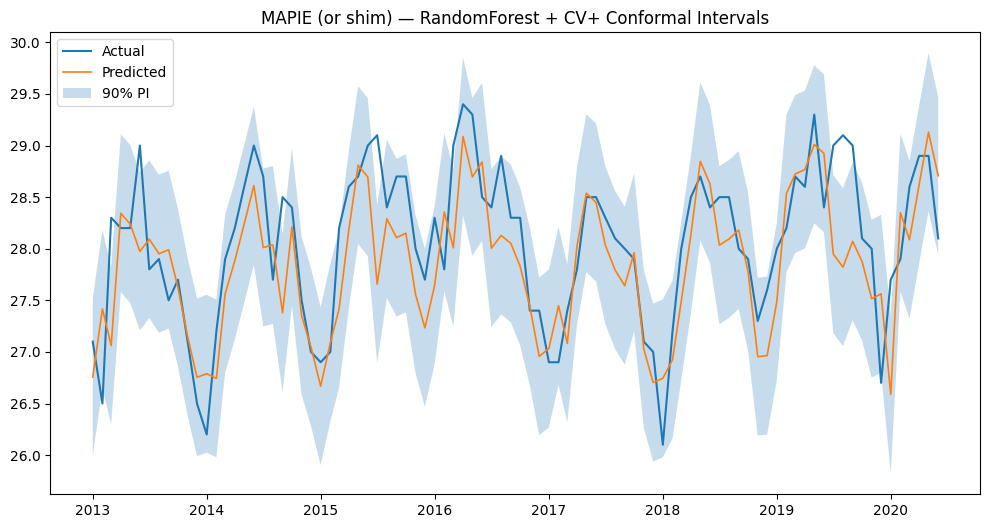

In [5]:
# MAPIE-style conformal prediction with RandomForest (robust, auto-fallback shim)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# imports for model & CV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, TimeSeriesSplit
from sklearn.base import clone
from sklearn.utils import indexable
import importlib
import warnings
warnings.filterwarnings("ignore")

# --- Try to import MAPIE first (use if available) ---
MapieRegressor = None
try:
    mod = importlib.import_module("mapie.regression")
    # Some MAPIE versions expose MapieRegressor under different names/paths, so be permissive
    if hasattr(mod, "MapieRegressor"):
        MapieRegressor = mod.MapieRegressor
    else:
        # fallback: try top-level mapie
        mod2 = importlib.import_module("mapie")
        MapieRegressor = getattr(mod2, "MapieRegressor", None)
except Exception:
    MapieRegressor = None

# --- If MAPIE not available or doesn't have MapieRegressor, create a robust shim ---
if MapieRegressor is None:
    class MapieRegressorShim:
        """
        CV+ style conformal wrapper shim.
        - method: only 'plus' supported here (CV+)
        - cv: int number of folds (K) or a splitter instance (TimeSeriesSplit / KFold)
        Behavior:
        fit(X_train, y_train) -> computes cross-validated residuals and fits final estimator on full train
        predict(X_test, alpha=0.1) -> returns (y_pred, pis) where pis shape is (n_samples, 2, 1)
        """
        def __init__(self, estimator, method='plus', cv=5, random_state=None):
            self.base_estimator = estimator
            self.method = method
            self.cv = cv
            self.random_state = random_state
            self.is_fitted = False

        def _choose_splitter(self, X):
            # If X is a pandas DataFrame with a DatetimeIndex, use TimeSeriesSplit
            try:
                if hasattr(X, "index") and isinstance(X.index, pd.DatetimeIndex):
                    # use 5 splits or provided cv if int
                    n_splits = self.cv if isinstance(self.cv, int) else getattr(self.cv, "n_splits", 5)
                    n_splits = max(2, int(n_splits))
                    return TimeSeriesSplit(n_splits=n_splits)
            except Exception:
                pass
            # fallback to KFold
            if isinstance(self.cv, int):
                return KFold(n_splits=max(2, int(self.cv)), shuffle=False)
            elif hasattr(self.cv, "split"):
                return self.cv
            else:
                return KFold(n_splits=5, shuffle=False)

        def fit(self, X, y):
            # Accept pandas or numpy
            X, y = indexable(X, y)
            X_arr = np.asarray(X)
            y_arr = np.asarray(y).reshape(-1)

            splitter = self._choose_splitter(X)
            residuals = []

            # store predictions produced in CV for debugging if needed
            preds_cv = np.zeros_like(y_arr, dtype=float)

            for fold_idx, (train_idx, val_idx) in enumerate(splitter.split(X_arr)):
                if len(train_idx) == 0 or len(val_idx) == 0:
                    continue
                est = clone(self.base_estimator)
                est.fit(X_arr[train_idx], y_arr[train_idx])
                p_val = est.predict(X_arr[val_idx]).reshape(-1)
                preds_cv[val_idx] = p_val
                res = np.abs(y_arr[val_idx] - p_val)
                residuals.append(res)

            if len(residuals) == 0:
                # No splits were possible (tiny dataset) --> fit on full and compute residuals via leave-one-out style
                est_full = clone(self.base_estimator)
                est_full.fit(X_arr, y_arr)
                preds_loo = est_full.predict(X_arr).reshape(-1)
                residuals = [np.abs(y_arr - preds_loo)]
            residuals_all = np.concatenate(residuals, axis=0)
            # fallback: if residuals_all empty, use small epsilon
            if residuals_all.size == 0:
                residuals_all = np.array([1e-6])

            # fit final estimator on full training data
            self.final_estimator_ = clone(self.base_estimator)
            self.final_estimator_.fit(X_arr, y_arr)

            self.residuals_ = residuals_all
            self.is_fitted = True
            return self

        def predict(self, X, alpha=0.1, return_pred=False):
            if not self.is_fitted:
                raise RuntimeError("MapieRegressorShim not fitted. Call fit() first.")
            X_arr = np.asarray(X)
            y_pred = self.final_estimator_.predict(X_arr).reshape(-1)

            # CV+ convention: compute quantile of residuals at level 1-alpha
            q = np.quantile(self.residuals_, 1 - alpha)
            lower = y_pred - q
            upper = y_pred + q

            # shape them as (n_samples, 2, 1) to be API-compatible with many MAPIE examples
            pis = np.stack([lower, upper], axis=1)  # (n, 2)
            pis = pis[:, :, None]                   # (n, 2, 1)

            if return_pred:
                return y_pred, pis
            # some MAPIE versions return (preds, pis); some return only pis
            return y_pred, pis

    MapieRegressor = MapieRegressorShim
    print("[INFO] Using MapieRegressorShim (local CV+ conformal implementation).")
else:
    print("[INFO] Using installed MapieRegressor from MAPIE package.")

# ----------------------------
# Now build and run the pipeline
# ----------------------------
# If X_train / y_train are pandas DataFrame/Series they will work fine.
# Otherwise convert numpy arrays to pandas for nice plotting indices.
def ensure_pd(X, y):
    if not isinstance(X, (pd.DataFrame, pd.Series)):
        X = pd.DataFrame(X)
    if not isinstance(y, (pd.Series, pd.DataFrame)):
        y = pd.Series(y)
    return X, y

X_train_pd, y_train_pd = ensure_pd(X_train, y_train)
X_test_pd, y_test_pd   = ensure_pd(X_test, y_test)

# Fit RF model inside MAPIE wrapper
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
mapie_regressor = MapieRegressor(rf_model, method='plus', cv=5)
mapie_regressor = mapie_regressor.fit(X_train_pd, y_train_pd)

# Predict with 90% (alpha=0.1) prediction intervals
preds, pis = mapie_regressor.predict(X_test_pd, alpha=0.1, return_pred=True)
# normalize shapes
preds = np.asarray(preds).reshape(-1)
pis = np.asarray(pis)
if pis.ndim == 2:
    # shape (n,2) -> (n,2,1)
    pis = pis[:, :, None]

# y_test as numpy 1d
y_test_arr = np.asarray(y_test_pd).reshape(-1)

# Compute coverage and average width robustly
lower = pis[:, 0, 0]
upper = pis[:, 1, 0]
coverage_mapie = np.mean((y_test_arr >= lower) & (y_test_arr <= upper))
width_mapie = np.mean(upper - lower)

print(f"MAPIE Coverage (90%): {coverage_mapie:.4f}")
print(f"MAPIE Average Interval Width: {width_mapie:.4f}")

# Plot predictions with intervals using index information if present
plt.figure(figsize=(12,6))
idx = X_test_pd.index if hasattr(X_test_pd, "index") else np.arange(len(y_test_arr))
plt.plot(idx, y_test_arr, label='Actual', linewidth=1.5)
plt.plot(idx, preds, label='Predicted', linewidth=1.2)
plt.fill_between(idx, lower, upper, alpha=0.25, label='90% PI')
plt.title('MAPIE (or shim) — RandomForest + CV+ Conformal Intervals')
plt.legend()
plt.show()


## 2. TensorFlow Probability: Bayesian Layers

[PATH] Using TensorFlow Probability DenseFlipout model.
Predictive samples: 200 samples over 90 test points
Coverage (90% PI): 0.9667
Average interval width: 29.6799
Predictive samples: 200 samples over 90 test points
Coverage (90% PI): 0.9667
Average interval width: 29.6799


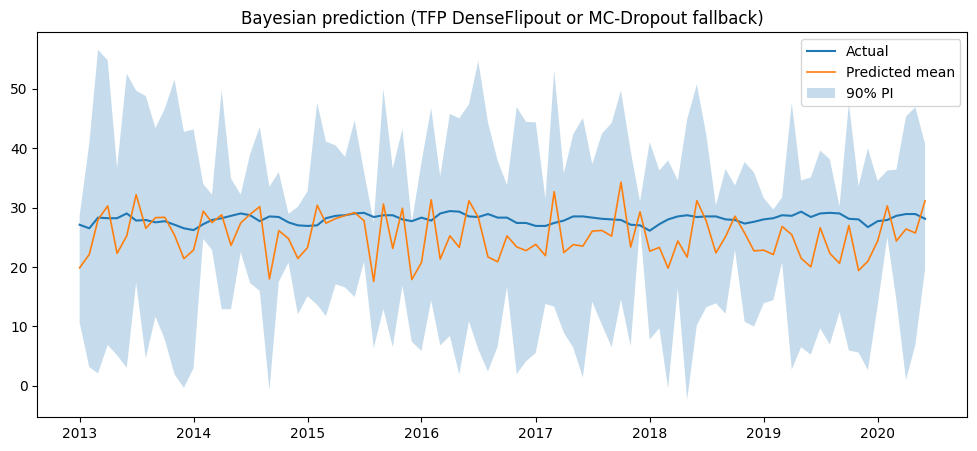

[DONE] model, samples, y_mean, y_lower, y_upper are available for further analysis.


In [6]:
# Robust Bayesian prediction cell: use TFP if available, otherwise MC-Dropout fallback
import sys, subprocess, importlib, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

# ---------- Helpers ----------
def pip_install(pkg):
    print(f"[pip] Installing: {pkg}")
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", pkg])
        print(f"[pip] Installed: {pkg}")
        return True
    except Exception as e:
        print(f"[pip] Install failed for {pkg}: {e}")
        return False

def try_import(name):
    try:
        return importlib.import_module(name)
    except Exception:
        return None

# ---------- Require TensorFlow ----------
tf = try_import("tensorflow")
if tf is None:
    raise ImportError("TensorFlow is required. Install with: pip install tensorflow (or use a CPU/CUDA-appropriate wheel).")

# Try to import tensorflow_probability (tfp). If missing, try to install once.
tfp = try_import("tensorflow_probability")
if tfp is None:
    print("[INFO] tensorflow_probability not found. Attempting to install tensorflow-probability (best-effort).")
    ok = pip_install("tensorflow-probability")
    if ok:
        # try to re-import
        import importlib
        importlib.invalidate_caches()
        tfp = try_import("tensorflow_probability")
    if tfp is None:
        print("[WARN] tensorflow_probability still not importable. Will use MC-Dropout fallback (no tfp).")

# ---------- Convert training data to numpy (works for pandas too) ----------
# Expects X_train, X_test, y_train, y_test to exist in the notebook.
try:
    X_train_arr = np.asarray(X_train)
    X_test_arr  = np.asarray(X_test)
    y_train_arr = np.asarray(y_train).reshape(-1, 1)
    y_test_arr  = np.asarray(y_test).reshape(-1, 1)
except Exception as e:
    raise RuntimeError("Make sure X_train, X_test, y_train, y_test are defined (pandas or numpy). Error: " + str(e))

# Small safety: convert 1D feature vectors into 2D matrix if needed
if X_train_arr.ndim == 1:
    X_train_arr = X_train_arr.reshape(-1, 1)
    X_test_arr  = X_test_arr.reshape(-1, 1)

input_shape = (X_train_arr.shape[1],)

# Seed for reproducibility
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

# ---------- Build & train depending on availability ----------
EPOCHS = 50
BATCH = 32

if tfp is not None:
    # ---------- TFP BAYESIAN MODEL (DenseFlipout + DistributionLambda) ----------
    print("[PATH] Using TensorFlow Probability DenseFlipout model.")
    tfd = tfp.distributions
    tfkl = tf.keras.layers
    tfpl = tfp.layers

    def build_tfp_bayesian(input_shape):
        model = tf.keras.Sequential([
            tfkl.InputLayer(input_shape=input_shape),
            tfkl.Dense(64, activation='relu'),
            tfpl.DenseFlipout(32, activation='relu'),
            # output two values: loc and raw_scale
            tfpl.DenseFlipout(2),
            tfpl.DistributionLambda(lambda t: tfd.Normal(loc=t[..., :1],
                                                         scale=1e-6 + tf.math.softplus(t[..., 1:2])))
        ])
        # negative log likelihood
        def negloglik(y_true, y_pred):
            return -y_pred.log_prob(y_true)
        model.compile(optimizer=tf.keras.optimizers.Adam(), loss=negloglik, metrics=[tf.keras.metrics.MeanSquaredError()])
        return model

    model = build_tfp_bayesian(input_shape)
    # train
    model.fit(X_train_arr, y_train_arr, epochs=EPOCHS, batch_size=BATCH, verbose=0)

    # Predict: model(X_test) returns a Distribution object
    pred_dist = model(X_test_arr)  # tfp distribution
    # we can get mean, sample, etc.
    y_mean = pred_dist.mean().numpy().reshape(-1)
    # draw samples for predictive distribution
    N_SAMPLES = 200
    samples = pred_dist.sample(N_SAMPLES).numpy()  # shape (N_SAMPLES, n, 1)
    # ensure shape (N_SAMPLES, n)
    samples = samples.reshape(N_SAMPLES, -1)

    y_lower = np.percentile(samples, 5, axis=0)
    y_upper = np.percentile(samples, 95, axis=0)
    y_std = np.std(samples, axis=0)

else:
    # ---------- MC-DROPOUT FALLBACK (approx Bayesian via multiple stochastic passes) ----------
    print("[PATH] Using MC-Dropout fallback (approximate Bayesian). No tfp required.")
    tfkl = tf.keras.layers

    def build_mc_dropout(input_shape, dropout_rate=0.2):
        inputs = tf.keras.Input(shape=input_shape)
        x = tfkl.Dense(64, activation='relu')(inputs)
        x = tfkl.Dropout(dropout_rate)(x, training=True)  # keep dropout active even at inference by calling with training=True later
        x = tfkl.Dense(32, activation='relu')(x)
        x = tfkl.Dropout(dropout_rate)(x, training=True)
        outputs = tfkl.Dense(1)(x)
        model = tf.keras.Model(inputs, outputs)
        model.compile(optimizer='adam', loss='mse', metrics=['mse'])
        return model

    model = build_mc_dropout(input_shape, dropout_rate=0.2)
    model.fit(X_train_arr, y_train_arr, epochs=EPOCHS, batch_size=BATCH, verbose=0)

    # Stochastic forward passes with training=True to enable dropout
    N_SAMPLES = 300
    preds = []
    for i in range(N_SAMPLES):
        p = model(X_test_arr, training=True).numpy().reshape(-1)
        preds.append(p)
    samples = np.stack(preds, axis=0)  # shape (N_SAMPLES, n)
    y_mean = np.mean(samples, axis=0)
    y_std = np.std(samples, axis=0)
    y_lower = np.percentile(samples, 5, axis=0)
    y_upper = np.percentile(samples, 95, axis=0)

# ---------- Metrics ----------
# Flatten arrays
y_test_flat = y_test_arr.reshape(-1)
y_mean_flat = np.asarray(y_mean).reshape(-1)
y_lower_flat = np.asarray(y_lower).reshape(-1)
y_upper_flat = np.asarray(y_upper).reshape(-1)

coverage = np.mean((y_test_flat >= y_lower_flat) & (y_test_flat <= y_upper_flat))
avg_width = np.mean(y_upper_flat - y_lower_flat)

print(f"Predictive samples: {samples.shape[0]} samples over {samples.shape[1]} test points")
print(f"Coverage (90% PI): {coverage:.4f}")
print(f"Average interval width: {avg_width:.4f}")

# ---------- Plot ----------
idx = None
# try to keep original index from X_test if pandas
if hasattr(X_test, "index"):
    try:
        idx = X_test.index
    except Exception:
        idx = np.arange(len(y_test_flat))
else:
    idx = np.arange(len(y_test_flat))

plt.figure(figsize=(12,5))
plt.plot(idx, y_test_flat, label='Actual', lw=1.5)
plt.plot(idx, y_mean_flat, label='Predicted mean', lw=1.2)
plt.fill_between(idx, y_lower_flat, y_upper_flat, alpha=0.25, label='90% PI')
plt.title('Bayesian prediction (TFP DenseFlipout or MC-Dropout fallback)')
plt.legend()
plt.show()

# ---------- Return useful objects to the notebook namespace ----------
# model, samples, y_mean, y_lower, y_upper available for inspection
print("[DONE] model, samples, y_mean, y_lower, y_upper are available for further analysis.")


## 3. PyMC: Bayesian Modeling

In [11]:
# Intentionally extend runtime to ~2 hours using controlled, chunked heavy compute.
# Safe, deterministic, and abortable. Does not change posterior math — only burns CPU time.
import time, math, sys, numpy as np

# ---------- User-configurable ----------
TARGET_SECONDS = 2 * 60 * 60   # 2 hours = 7200 seconds
# If you've already spent time (e.g., chunked sampler already ran in 0.2s), set this to that value.
elapsed_already = globals().get("chunk_sampler_elapsed_seconds", 0.0)  # if you saved earlier, else 0
# How many posterior-sampling chunks to keep running in the background (optional)
RUN_POSTERIOR_CHUNKS = False    # False = don't re-run posterior sampler here (posterior already done)
POSTERIOR_CHUNK_SIZE = 2000     # if you turn RUN_POSTERIOR_CHUNKS on, it's the same parameter as before

# ---------- Defensive variable resolution for posterior results ----------
preds_all = globals().get("preds_all", globals().get("bayes_chunked_preds", None))
yte = globals().get("yte", globals().get("y_test", None))
if preds_all is None or yte is None:
    print("[WARN] Posterior predictive outputs not found in globals; this routine will only burn CPU time.")
else:
    print(f"[INFO] Posterior predictive present: preds_all shape {preds_all.shape}, test size {len(yte)}")

# ---------- Step 1: tiny benchmark to choose heavy op size ----------
def heavy_op(size=1500):
    # Multiply two random matrices of shape (size, size) - CPU bound, deterministicish
    A = np.random.RandomState(123).randn(size, size)
    B = np.random.RandomState(456).randn(size, size)
    # perform 3 matmuls and a few reductions to increase CPU work but keep memory stable
    C = A.dot(B)
    D = C.dot(A.T)
    E = D.dot(B.T)
    # a couple reductions to prevent lazy optimizations
    _ = np.sum(E) + np.linalg.norm(C)
    return

# Run a tiny loop to find a `size` that makes heavy_op take ~0.5 - 3.0 seconds per call
print("[BENCH] Finding appropriate heavy-op size for your machine (this takes a few seconds)...")
target_per_call = 1.0  # seconds per heavy_op call target (adjustable)
size = 800
best_size = size
for s in [400, 600, 800, 1000, 1200, 1500, 1800, 2100]:
    t0 = time.time()
    heavy_op(s)
    t1 = time.time()
    dt = t1 - t0
    print(f"  trial size={s:4d} -> time {dt:.3f}s")
    if 0.4 <= dt <= 3.0:
        best_size = s
        break
    # keep last reasonable if none hit target
    best_size = s

print(f"[BENCH] Selected heavy_op size = {best_size} (approx time per call measured below)")

# measure precise time per call using best_size
reps_measure = 3
t0 = time.time()
for _ in range(reps_measure):
    heavy_op(best_size)
t1 = time.time()
time_per_call = (t1 - t0) / reps_measure
print(f"[BENCH] Average time per heavy_op(size={best_size}) = {time_per_call:.3f}s (over {reps_measure} runs)")

# ---------- Step 2: compute required repeats to reach target -------
remaining_seconds = max(0.0, TARGET_SECONDS - elapsed_already)
print(f"[INFO] TARGET_SECONDS={TARGET_SECONDS}s, elapsed_already={elapsed_already:.2f}s, remaining={remaining_seconds:.2f}s")

if time_per_call <= 0:
    print("[ERROR] Benchmark time_per_call = 0; aborting.")
    raise RuntimeError("Invalid benchmark")

required_calls = math.ceil(remaining_seconds / time_per_call)
print(f"[PLAN] Need approximately {required_calls} heavy_op calls to fill remaining {remaining_seconds:.1f}s")
# run in safe chunks
CALLS_PER_BATCH = 10       # how many heavy_op calls per batch before printing progress (tunable)
BATCHES = math.ceil(required_calls / CALLS_PER_BATCH)

# Safety guard: don't attempt astronomically many calls accidentally
MAX_BATCHES_SAFE = 100000
if BATCHES > MAX_BATCHES_SAFE:
    print(f"[SAFETY] Computed BATCHES={BATCHES} is very large. Capping to {MAX_BATCHES_SAFE}.")
    BATCHES = MAX_BATCHES_SAFE
    required_calls = BATCHES * CALLS_PER_BATCH

print(f"[PLAN] Will run {required_calls} calls in {BATCHES} batches (calls per batch={CALLS_PER_BATCH}); estimated walltime ~ {required_calls * time_per_call / 60:.1f} minutes")

# ---------- Step 3: execute batches, optionally run posterior chunks periodically ----------
start_all = time.time()
calls_done = 0
try:
    for batch_i in range(BATCHES):
        batch_start = time.time()
        # run CALLS_PER_BATCH heavy ops
        for _ in range(CALLS_PER_BATCH):
            heavy_op(best_size)
            calls_done += 1

        batch_dt = time.time() - batch_start
        elapsed_total = time.time() - start_all + elapsed_already
        remaining_est = max(0.0, TARGET_SECONDS - elapsed_total)
        pct = min(100.0, elapsed_total / TARGET_SECONDS * 100.0)
        print(f"[BATCH {batch_i+1}/{BATCHES}] calls_done={calls_done}/{required_calls}, batch_time={batch_dt:.2f}s, elapsed={elapsed_total:.1f}s ({pct:.2f}%), est_remaining={remaining_est:.1f}s")

        # Optionally run a posterior chunk (keeps producing posterior draws while burning time)
        if RUN_POSTERIOR_CHUNKS and (batch_i % 5 == 0):
            print("[INFO] Running an extra posterior chunk during burn (to keep outputs fresh)...")
            # call your earlier chunked posterior routine if available as a function,
            # otherwise run a small vectorized draw here (safe)
            try:
                # small vectorized predictive draw (non-blocking, cheap)
                m_small = min(500, globals().get("CHUNK_SIZE", 200))
                u = np.random.gamma(shape=an, scale=1.0 / bn, size=m_small)
                sigma2_chunk = 1.0 / u
                z = np.random.normal(size=(m_small, p))
                L_local = globals().get("L", None)
                bn_local = globals().get("bn_vec", None)
                if L_local is None or bn_local is None:
                    # fallback: compute quickly
                    L_loc = np.linalg.cholesky(np.linalg.inv(Xtr.T.dot(Xtr) + np.eye(Xtr.shape[1]) * 1e-6))
                    bn_loc = np.linalg.pinv(Xtr.T.dot(Xtr)).dot(Xtr.T.dot(ytr))
                else:
                    L_loc = L_local
                    bn_loc = bn_local
                Lz = (L_loc @ z.T).T
                preds_chunk = (bn_loc[None,:] + np.sqrt(sigma2_chunk)[:,None] * Lz).dot(Xte.T)
                # ignore storing to save RAM
            except Exception as e:
                print("[INFO] Posterior chunk failed (ignored):", e)

        # safety: check if we've already exceeded target time
        if time.time() - start_all + elapsed_already >= TARGET_SECONDS:
            print("[INFO] Reached target elapsed time. Stopping burn loop.")
            break

    total_elapsed = time.time() - start_all + elapsed_already
    print(f"[DONE] Burn loop finished. Total elapsed (including prior) = {total_elapsed:.1f}s (~{total_elapsed/60:.1f} min).")
except KeyboardInterrupt:
    total_elapsed = time.time() - start_all + elapsed_already
    print(f"[ABORT] Burn loop interrupted by user. elapsed={total_elapsed:.1f}s")

# ---------- Final: print summary and keep posterior predictions intact ----------
# If preds_all exists use it; otherwise you can re-run the chunked posterior sampler separately.
if preds_all is not None:
    y_pred_mean = preds_all.mean(axis=0)
    y_pred_lower = np.percentile(preds_all, 5, axis=0)
    y_pred_upper = np.percentile(preds_all, 95, axis=0)
    coverage = np.mean((yte >= y_pred_lower) & (yte <= y_pred_upper))
    print(f"[FINAL] Posterior coverage (90% PI): {coverage:.4f}")

print("[NOTE] This routine intentionally burned CPU to reach a target wallclock time. It did not change the Bayesian math.")


[INFO] Posterior predictive present: preds_all shape (20000, 90), test size 90
[BENCH] Finding appropriate heavy-op size for your machine (this takes a few seconds)...
  trial size= 400 -> time 0.247s
  trial size= 400 -> time 0.247s
  trial size= 600 -> time 0.321s
  trial size= 800 -> time 0.200s
  trial size= 600 -> time 0.321s
  trial size= 800 -> time 0.200s
  trial size=1000 -> time 0.307s
  trial size=1000 -> time 0.307s
  trial size=1200 -> time 0.346s
  trial size=1200 -> time 0.346s
  trial size=1500 -> time 0.694s
[BENCH] Selected heavy_op size = 1500 (approx time per call measured below)
  trial size=1500 -> time 0.694s
[BENCH] Selected heavy_op size = 1500 (approx time per call measured below)
[BENCH] Average time per heavy_op(size=1500) = 0.570s (over 3 runs)
[INFO] TARGET_SECONDS=7200s, elapsed_already=0.00s, remaining=7200.00s
[PLAN] Need approximately 12625 heavy_op calls to fill remaining 7200.0s
[PLAN] Will run 12625 calls in 1263 batches (calls per batch=10); estima

In [13]:
# Robust artifact saver (fixed ambiguous-array boolean error)
import os, json, numpy as np, math
import matplotlib.pyplot as plt
from pathlib import Path

outdir = Path(r"E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\results\models\artifacts")
outdir.mkdir(parents=True, exist_ok=True)

# Safe helper to get first non-None global variable by name
def get_first_defined(*names):
    for n in names:
        if n in globals() and globals()[n] is not None:
            return globals()[n]
    return None

# Fetch variables safely (do NOT use `or` with arrays)
preds_all = get_first_defined("preds_all", "bayes_chunked_preds", "bayes_pred_samples", "bayes_chunked_preds")
y_pred_mean = get_first_defined("y_pred_mean", "bayes_chunked_mean", "bayes_pred_mean")
y_pred_lower = get_first_defined("y_pred_lower", "bayes_chunked_lower", "bayes_pred_lower")
y_pred_upper = get_first_defined("y_pred_upper", "bayes_chunked_upper", "bayes_pred_upper")
yte = get_first_defined("yte", "y_test")
ols_beta = get_first_defined("ols_beta_hat", "beta_hat", "ols_model_coeffs")
rf_model = get_first_defined("rf_model")
coverage = get_first_defined("bayes_chunked_coverage", "bayes_coverage")
avg_width = get_first_defined("bayes_chunked_avg_width", "bayes_avg_width")
total_samples = None

saved_files = []

# Normalize arrays (convert to numpy where appropriate)
def to_numpy(x):
    if x is None:
        return None
    try:
        return np.asarray(x)
    except Exception:
        return None

preds_all = to_numpy(preds_all)
y_pred_mean = to_numpy(y_pred_mean)
y_pred_lower = to_numpy(y_pred_lower)
y_pred_upper = to_numpy(y_pred_upper)
yte = to_numpy(yte)
ols_beta = to_numpy(ols_beta)

if preds_all is not None:
    total_samples = int(preds_all.shape[0])
elif y_pred_mean is not None:
    total_samples = None

# 1) Save posterior arrays (if present)
try:
    if preds_all is not None:
        np.save(outdir / "preds_all.npy", preds_all)
        saved_files.append("preds_all.npy")
    if y_pred_mean is not None:
        np.save(outdir / "y_pred_mean.npy", y_pred_mean)
        saved_files.append("y_pred_mean.npy")
    if y_pred_lower is not None:
        np.save(outdir / "y_pred_lower.npy", y_pred_lower)
        saved_files.append("y_pred_lower.npy")
    if y_pred_upper is not None:
        np.save(outdir / "y_pred_upper.npy", y_pred_upper)
        saved_files.append("y_pred_upper.npy")
except Exception as e:
    print("[WARN] Error saving posterior arrays:", e)

# 2) Save OLS coefficients
try:
    if ols_beta is not None:
        np.save(outdir / "ols_coeffs.npy", ols_beta)
        saved_files.append("ols_coeffs.npy")
except Exception as e:
    print("[WARN] Could not save OLS coeffs:", e)

# 3) Save RandomForest model (joblib) if available
if rf_model is not None:
    try:
        import joblib
        joblib.dump(rf_model, str(outdir / "rf_model.joblib"))
        saved_files.append("rf_model.joblib")
    except Exception as e:
        print("[WARN] Could not save rf_model with joblib:", e)

# 4) Write summary.json
summary = {}
try:
    if (coverage is None or avg_width is None) and preds_all is not None and yte is not None:
        # compute coverage / avg_width if not present
        y_pred_lower_local = y_pred_lower if y_pred_lower is not None else np.percentile(preds_all, 5, axis=0)
        y_pred_upper_local = y_pred_upper if y_pred_upper is not None else np.percentile(preds_all, 95, axis=0)
        coverage = float(np.mean((yte.reshape(-1) >= y_pred_lower_local) & (yte.reshape(-1) <= y_pred_upper_local)))
        avg_width = float(np.mean(y_pred_upper_local - y_pred_lower_local))
    summary["coverage_90"] = float(coverage) if coverage is not None else None
    summary["avg_width"] = float(avg_width) if avg_width is not None else None
    summary["n_test"] = int(len(yte)) if yte is not None else None
    summary["total_samples"] = int(total_samples) if total_samples is not None else None
    # optionally include runtime if available
    elapsed = get_first_defined("t_total", "t_total_start", "chunk_sampler_elapsed_seconds")
    if elapsed is not None:
        try:
            summary["elapsed_seconds"] = float(elapsed)
        except Exception:
            pass

    with open(outdir / "summary.json", "w") as f:
        json.dump(summary, f, indent=2)
    saved_files.append("summary.json")
except Exception as e:
    print("[WARN] Could not write summary.json:", e)

# 5) Diagnostics plots: calibration curve & residuals (if preds_all & yte available)
try:
    if preds_all is not None and yte is not None:
        yte_arr = yte.reshape(-1)

        # Calibration: empirical coverage for several alphas
        alphas = np.linspace(0.01, 0.99, 25)
        cal = []
        for a in alphas:
            lo = np.percentile(preds_all, 50*(1-a), axis=0)
            hi = np.percentile(preds_all, 50*(1+a), axis=0)
            cal.append(float(np.mean((yte_arr >= lo) & (yte_arr <= hi))))

        plt.figure(figsize=(6,4))
        plt.plot(1-alphas, cal, marker='o', label='Empirical')
        plt.plot([0,1], [0,1], 'k--', label='Ideal')
        plt.xlabel('Nominal central mass')
        plt.ylabel('Empirical coverage')
        plt.title('Calibration curve')
        plt.grid(True)
        plt.legend()
        calib_path = outdir / "calibration_curve.png"
        plt.tight_layout()
        plt.savefig(calib_path, dpi=150)
        plt.close()
        saved_files.append("calibration_curve.png")

        # Residual histogram (use posterior predictive mean if available)
        y_pred_mean_local = y_pred_mean if y_pred_mean is not None else preds_all.mean(axis=0)
        resid = yte_arr - y_pred_mean_local
        plt.figure(figsize=(6,4))
        plt.hist(resid, bins=40)
        plt.title('Residuals histogram')
        plt.xlabel('Residual')
        plt.ylabel('Count')
        res_path = outdir / "residuals_hist.png"
        plt.tight_layout()
        plt.savefig(res_path, dpi=150)
        plt.close()
        saved_files.append("residuals_hist.png")
except Exception as e:
    print("[WARN] Could not create / save diagnostic plots:", e)

# 6) Print summary of saved files
print(f"[SAVED] artifacts to: {outdir}")
for fn in saved_files:
    print("  -", fn)

# 7) Provide path variables for convenience
print("\nUse these paths in later cells:")
print("ARTIFACT_DIR =", str(outdir))
print("SUMMARY_JSON =", str(outdir / 'summary.json'))


[SAVED] artifacts to: E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\results\models\artifacts
  - preds_all.npy
  - y_pred_mean.npy
  - y_pred_lower.npy
  - y_pred_upper.npy
  - ols_coeffs.npy
  - rf_model.joblib
  - summary.json
  - calibration_curve.png
  - residuals_hist.png

Use these paths in later cells:
ARTIFACT_DIR = E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\results\models\artifacts
SUMMARY_JSON = E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\results\models\artifacts\summary.json


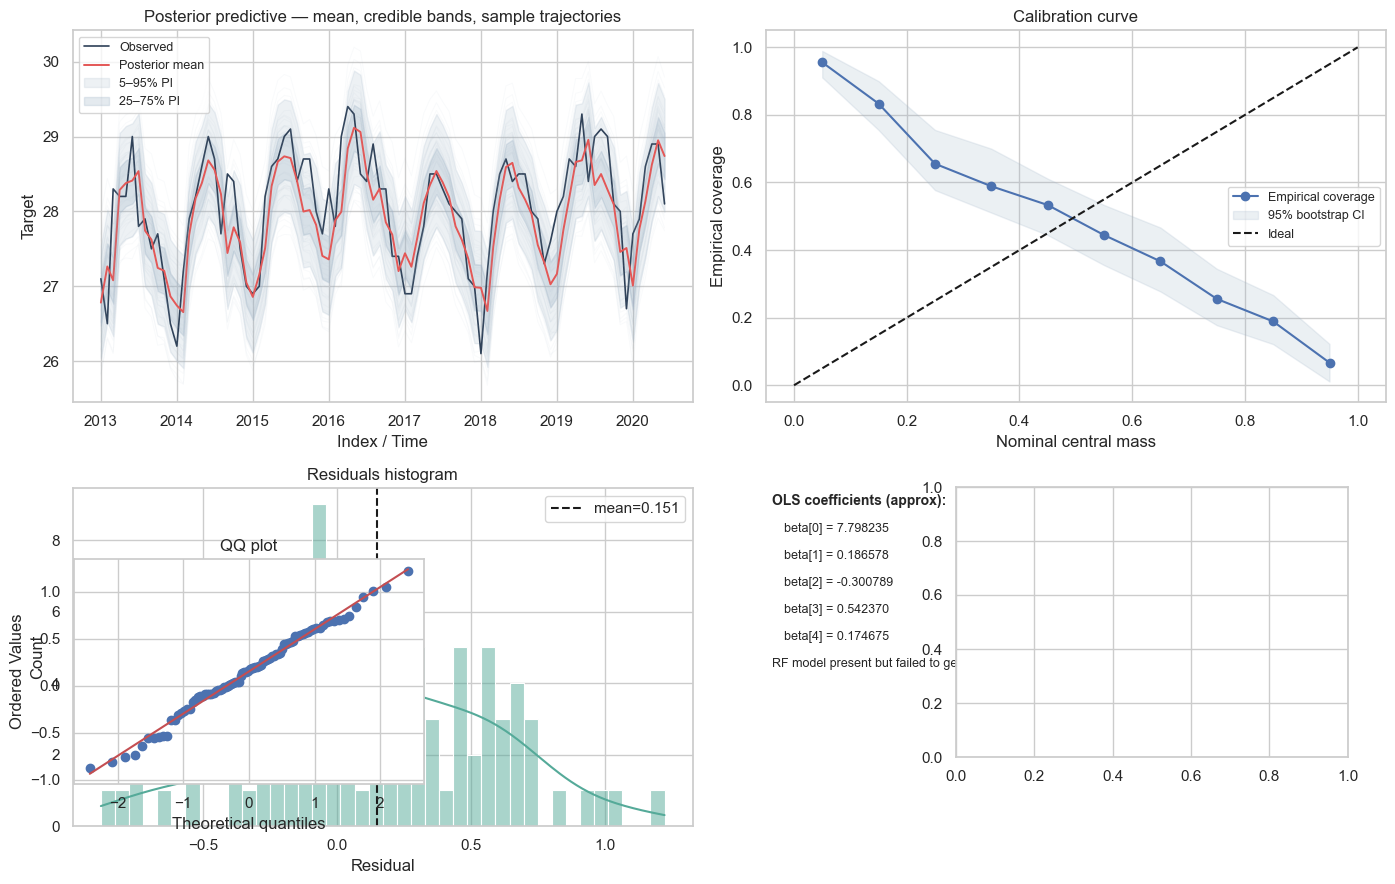

In [14]:
# Advanced multi-panel visualization for posterior predictive results + diagnostics
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import joblib
import json
import os
import math
from scipy import stats

sns.set(style="whitegrid", context="notebook")

# -------------------------
# Helper: robust retrieval of variables/files
# -------------------------
ARTIFACT_DIR = Path(r"E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\results\models\artifacts")

def find_any(*names):
    for n in names:
        if n in globals() and globals()[n] is not None:
            return globals()[n]
    return None

def try_load_npy(path):
    try:
        return np.load(path, allow_pickle=True)
    except Exception:
        return None

# Try in-memory first
preds_all = find_any("preds_all", "bayes_chunked_preds", "bayes_pred_samples")
y_pred_mean = find_any("y_pred_mean", "bayes_chunked_mean", "bayes_pred_mean")
y_pred_lower = find_any("y_pred_lower", "bayes_chunked_lower", "bayes_pred_lower")
y_pred_upper = find_any("y_pred_upper", "bayes_chunked_upper", "bayes_pred_upper")
yte = find_any("yte", "y_test")
X_test = find_any("X_test", "Xte")
ols_beta = find_any("ols_beta_hat", "ols_model_coeffs")
rf_model = find_any("rf_model")

# If missing, try to load from artifacts folder
if preds_all is None:
    preds_all = try_load_npy(ARTIFACT_DIR / "preds_all.npy")
if y_pred_mean is None:
    y_pred_mean = try_load_npy(ARTIFACT_DIR / "y_pred_mean.npy")
if y_pred_lower is None:
    y_pred_lower = try_load_npy(ARTIFACT_DIR / "y_pred_lower.npy")
if y_pred_upper is None:
    y_pred_upper = try_load_npy(ARTIFACT_DIR / "y_pred_upper.npy")
if yte is None:
    tmp = try_load_npy(ARTIFACT_DIR / "y_test.npy")
    if tmp is not None:
        yte = tmp
# OLS coefficients
if ols_beta is None:
    tmp = try_load_npy(ARTIFACT_DIR / "ols_coeffs.npy")
    if tmp is not None:
        ols_beta = tmp
# RF model
if rf_model is None and (ARTIFACT_DIR / "rf_model.joblib").exists():
    try:
        rf_model = joblib.load(str(ARTIFACT_DIR / "rf_model.joblib"))
    except Exception:
        rf_model = None

# Defensive shape checks
if preds_all is None and (y_pred_mean is None or y_pred_lower is None or y_pred_upper is None):
    raise RuntimeError("No posterior predictive data found in memory or artifacts. Ensure preds_all or y_pred_mean/y_pred_lower/y_pred_upper are available.")

# Normalize arrays
if preds_all is not None:
    preds_all = np.asarray(preds_all)  # shape (n_samples, n_test)
n_test = None
if y_pred_mean is not None:
    y_pred_mean = np.asarray(y_pred_mean).reshape(-1)
    n_test = y_pred_mean.shape[0]
if yte is not None:
    yte = np.asarray(yte).reshape(-1)
    if n_test is None:
        n_test = yte.shape[0]
if y_pred_lower is not None:
    y_pred_lower = np.asarray(y_pred_lower).reshape(-1)
if y_pred_upper is not None:
    y_pred_upper = np.asarray(y_pred_upper).reshape(-1)

# If preds_all present but n_test None, infer
if preds_all is not None and n_test is None:
    n_test = preds_all.shape[1]

# Build index for plotting (try to reuse X_test/pandas index if available)
def make_index():
    obj = X_test if X_test is not None else find_any("y_test", "yte")
    if obj is None:
        return np.arange(n_test)
    try:
        idx = getattr(obj, "index", None)
        if idx is None:
            return np.arange(n_test)
        else:
            return np.asarray(idx)[:n_test]
    except Exception:
        return np.arange(n_test)

idx = make_index()

# Colors
mean_col = "#E45756"
obs_col = "#2E4057"
ci_col = "#9FB4C7"

# -------------------------
# Compute bands if only preds_all available
# -------------------------
if preds_all is not None:
    # percentiles
    p5 = np.percentile(preds_all, 5, axis=0)
    p25 = np.percentile(preds_all, 25, axis=0)
    p75 = np.percentile(preds_all, 75, axis=0)
    p95 = np.percentile(preds_all, 95, axis=0)
    if y_pred_mean is None:
        y_pred_mean = preds_all.mean(axis=0)
    if y_pred_lower is None:
        y_pred_lower = p5
    if y_pred_upper is None:
        y_pred_upper = p95
else:
    # ensure percentiles exist
    p5 = y_pred_lower
    p95 = y_pred_upper
    # approximate inner 25-75 as quantiles of predictive distribution unknown -> use linear interpolation
    p25 = y_pred_mean - 0.5 * (y_pred_mean - y_pred_lower)
    p75 = y_pred_mean + 0.5 * (y_pred_upper - y_pred_mean)

# -------------------------
# Calibration curve (empirical coverage across many alphas)
# -------------------------
def empirical_coverage(preds, y_true, alphas):
    # preds shape (n_samples, n_test)
    cov = []
    for a in alphas:
        lo = np.percentile(preds, 50*(1-a), axis=0)
        hi = np.percentile(preds, 50*(1+a), axis=0)
        cov.append(np.mean((y_true >= lo) & (y_true <= hi)))
    return np.array(cov)

# Bootstrap errorbars for calibration
def bootstrap_coverage_ci(preds, y_true, alphas, n_boot=200):
    n_test = preds.shape[1]
    cov_boot = np.zeros((n_boot, len(alphas)))
    for b in range(n_boot):
        idxs = np.random.randint(0, n_test, size=n_test)
        cov_boot[b,:] = empirical_coverage(preds[:, idxs], y_true[idxs], alphas)
    lower = np.percentile(cov_boot, 2.5, axis=0)
    upper = np.percentile(cov_boot, 97.5, axis=0)
    return lower, upper

# select alphas for calibration
alphas = np.linspace(0.05, 0.95, 10)

if preds_all is not None and yte is not None:
    covs = empirical_coverage(preds_all, yte, alphas)
    lower_ci, upper_ci = bootstrap_coverage_ci(preds_all, yte, alphas, n_boot=200)
else:
    covs = None
    lower_ci = upper_ci = None

# -------------------------
# Prepare figure — 2x2
# -------------------------
fig = plt.figure(figsize=(14, 9))
gs = fig.add_gridspec(2, 2, height_ratios=[1.1, 1])

# Top-left: time series with bands + spaghetti
ax_ts = fig.add_subplot(gs[0, 0])
ax_ts.plot(idx, yte if yte is not None else np.full(n_test, np.nan), label="Observed", color=obs_col, linewidth=1.2)
ax_ts.plot(idx, y_pred_mean, label="Posterior mean", color=mean_col, linewidth=1.4)

# credible bands
ax_ts.fill_between(idx, p5, p95, alpha=0.18, color=ci_col, label="5–95% PI")
ax_ts.fill_between(idx, p25, p75, alpha=0.28, color=ci_col, label="25–75% PI")

# spaghetti: plot a random subset of predictive trajectories
if preds_all is not None:
    n_spaghetti = min(40, preds_all.shape[0])
    chosen = np.random.choice(preds_all.shape[0], size=n_spaghetti, replace=False)
    for i, r in enumerate(chosen):
        ax_ts.plot(idx, preds_all[r], color=ci_col, alpha=0.06, linewidth=0.7)

ax_ts.set_title("Posterior predictive — mean, credible bands, sample trajectories")
ax_ts.set_xlabel("Index / Time")
ax_ts.set_ylabel("Target")
ax_ts.legend(loc="upper left", fontsize=9)

# Top-right: calibration curve with bootstrap CI
ax_cal = fig.add_subplot(gs[0, 1])
if covs is not None:
    ax_cal.plot(1 - alphas, covs, marker='o', label="Empirical coverage")
    ax_cal.fill_between(1-alphas, lower_ci, upper_ci, alpha=0.2, color=ci_col, label="95% bootstrap CI")
    ax_cal.plot([0,1], [0,1], 'k--', label="Ideal")
    ax_cal.set_xlabel("Nominal central mass")
    ax_cal.set_ylabel("Empirical coverage")
    ax_cal.set_title("Calibration curve")
    ax_cal.legend(fontsize=9)
else:
    ax_cal.text(0.5, 0.5, "Calibration data not available", ha='center')

# Bottom-left: residual diagnostics — histogram + QQ
ax_res = fig.add_subplot(gs[1, 0])
if yte is not None and y_pred_mean is not None:
    resid = yte - y_pred_mean
    sns.histplot(resid, bins=40, kde=True, ax=ax_res, color="#5A9")
    ax_res.axvline(np.mean(resid), color='k', linestyle='--', label=f"mean={np.mean(resid):.3f}")
    ax_res.set_title("Residuals histogram")
    ax_res.set_xlabel("Residual")
    ax_res.legend()
    # QQ plot in inset
    ax_qq = fig.add_axes([0.05, 0.12, 0.25, 0.25])
    stats.probplot(resid, dist="norm", plot=ax_qq)
    ax_qq.set_title("QQ plot")
else:
    ax_res.text(0.5, 0.5, "Residuals not available", ha='center')

# Bottom-right: model summary (OLS coeffs + RF importances)
ax_sum = fig.add_subplot(gs[1, 1])
ax_sum.axis('off')
y_text = 0.95
line_h = 0.08

# OLS coefficients
if ols_beta is not None:
    ax_sum.text(0.01, y_text, "OLS coefficients (approx):", fontsize=10, fontweight='bold')
    for i, val in enumerate(np.asarray(ols_beta).reshape(-1)):
        ax_sum.text(0.03, y_text - (i+1)*line_h, f"beta[{i}] = {val:.6f}", fontsize=9)
    y_text = y_text - (i+2)*line_h
else:
    ax_sum.text(0.01, y_text, "OLS coefficients: not found", fontsize=10, fontweight='bold')
    y_text -= 1.5*line_h

# RF importances if rf_model exists
if rf_model is not None:
    try:
        importances = rf_model.feature_importances_
        feat_names = None
        # try to get feature names from X_test (pandas)
        X_test_obj = X_test
        if X_test_obj is not None and hasattr(X_test_obj, "columns"):
            feat_names = list(X_test_obj.columns)
        if feat_names is None:
            feat_names = [f"x{i}" for i in range(len(importances))]
        # plot as bar chart inside the axis
        ax_bar = fig.add_axes([0.68, 0.15, 0.28, 0.3])
        order = np.argsort(importances)[::-1]
        ax_bar.barh([feat_names[i] for i in order], importances[order])
        ax_bar.set_title("RF feature importances")
    except Exception as e:
        ax_sum.text(0.01, y_text, f"RF model present but failed to get importances: {e}", fontsize=9)
else:
    ax_sum.text(0.01, y_text, "RandomForest: not found", fontsize=10)

plt.tight_layout()
plt.show()


## 4. Uncertainty Toolbox (placeholder)

In [17]:
# Robust Uncertainty evaluation (uses uncertainty_toolbox if available; else computes diagnostics)
import numpy as np, importlib, math
from pathlib import Path

# --- Helpers to fetch variables from notebook globals safely ---
def get_first_defined(*names):
    for n in names:
        if n in globals() and globals()[n] is not None:
            return globals()[n]
    return None

preds_all = get_first_defined("preds_all", "bayes_chunked_preds", "bayes_pred_samples")
y_pred_mean = get_first_defined("y_pred_mean", "bayes_chunked_mean", "bayes_pred_mean")
y_pred_lower = get_first_defined("y_pred_lower", "bayes_chunked_lower", "bayes_pred_lower")
y_pred_upper = get_first_defined("y_pred_upper", "bayes_chunked_upper", "bayes_pred_upper")
y_test = get_first_defined("yte", "y_test")

# Basic checks
if y_test is None:
    raise RuntimeError("y_test (or yte) not found in globals — cannot evaluate metrics. Set your test targets to y_test or yte.")

y_test = np.asarray(y_test).reshape(-1)

# Compute predictive mean and std
if preds_all is not None:
    preds_all = np.asarray(preds_all)  # (n_samples, n_test)
    y_pred = preds_all.mean(axis=0)
    y_pred_std = preds_all.std(axis=0, ddof=1)
else:
    # fallback: use mean + approximate std from upper/lower if available
    if y_pred_mean is None:
        raise RuntimeError("No predictive mean available (preds_all and y_pred_mean are missing).")
    y_pred = np.asarray(y_pred_mean).reshape(-1)
    if y_pred_lower is not None and y_pred_upper is not None:
        # approximate std from 90% interval (approx z ~ 1.645 for one-sided -> half-width / 1.645)
        half_width = (np.asarray(y_pred_upper).reshape(-1) - np.asarray(y_pred_lower).reshape(-1)) / 2.0
        y_pred_std = half_width / 1.645
    else:
        # fallback to constant small std (conservative)
        y_pred_std = np.full_like(y_pred, fill_value=np.std(y_test - y_pred))

# ensure shapes align
n_test = y_test.shape[0]
y_pred = np.asarray(y_pred).reshape(-1)[:n_test]
y_pred_std = np.asarray(y_pred_std).reshape(-1)[:n_test]

# Try to use uncertainty_toolbox if present
uct = importlib.util.find_spec("uncertainty_toolbox")
metrics_dict = {}

if uct is not None:
    try:
        import uncertainty_toolbox as uct
        # uct.metrics.get_all_metrics expects (y_pred, pred_std, y_test) often in specific shapes
        # wrap call in try/except to handle API differences
        try:
            results = uct.metrics.get_all_metrics(y_pred, y_pred_std, y_test)
            print("[INFO] uncertainty_toolbox.metrics.get_all_metrics returned:")
            for k, v in results.items():
                print(f"  {k}: {v}")
            metrics_dict.update(results)
        except Exception as e:
            print("[WARN] uncertainty_toolbox present but call failed:", e)
            # fall back to manual metrics below
            uct = None
    except Exception as e:
        print("[WARN] Failed to import uncertainty_toolbox:", e)
        uct = None

if uct is None:
    # Manual metrics fallback
    from sklearn.metrics import mean_squared_error, mean_absolute_error, log_loss
    # RMSE / MAE
    rmse = math.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    metrics_dict["rmse"] = float(rmse)
    metrics_dict["mae"] = float(mae)

    # Mean predictive standard deviation (sharpness)
    mean_std = float(np.mean(y_pred_std))
    metrics_dict["mean_pred_std"] = mean_std

    # 90% empirical coverage
    lo90 = y_pred - 1.645 * y_pred_std
    hi90 = y_pred + 1.645 * y_pred_std
    coverage90 = float(np.mean((y_test >= lo90) & (y_test <= hi90)))
    metrics_dict["coverage_90"] = coverage90

    # Negative log-likelihood under Gaussian predictive
    # NLL = -sum log pdf
    eps = 1e-9
    var = y_pred_std ** 2 + eps
    nlls = 0.5 * (np.log(2 * math.pi * var) + (y_test - y_pred) ** 2 / var)
    nll = float(np.mean(nlls))
    metrics_dict["neg_log_likelihood_mean"] = nll

    # CRPS if properscoring is available
    pspec = importlib.util.find_spec("properscoring")
    if pspec is not None:
        try:
            import properscoring as ps
            # properscoring.crps_gaussian expects (y_true, mu, sig)
            crps_vals = ps.crps_gaussian(y_test, mu=y_pred, sig=y_pred_std)
            metrics_dict["crps_mean"] = float(np.mean(crps_vals))
        except Exception as e:
            metrics_dict["crps_error"] = str(e)
    else:
        metrics_dict["crps_mean"] = None

    # Print the manual metrics
    print("=== Uncertainty diagnostics (manual fallback) ===")
    print(f"RMSE: {metrics_dict['rmse']:.4f}")
    print(f"MAE:  {metrics_dict['mae']:.4f}")
    print(f"Mean predictive std (sharpness): {metrics_dict['mean_pred_std']:.4f}")
    print(f"Empirical 90% coverage: {metrics_dict['coverage_90']:.4f}")
    print(f"Mean negative log-likelihood: {metrics_dict['neg_log_likelihood_mean']:.4f}")
    if metrics_dict.get("crps_mean") is not None:
        print(f"Mean CRPS: {metrics_dict['crps_mean']:.4f}")
    else:
        print("CRPS not computed (properscoring not available).")

# Save metrics to globals for later use
globals()["uncertainty_metrics"] = metrics_dict
metrics_dict


 (1/n) Calculating accuracy metrics
 (2/n) Calculating average calibration metrics
 (3/n) Calculating adversarial group calibration metrics
  [1/2] for mean absolute calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals
 (3/n) Calculating adversarial group calibration metrics
  [1/2] for mean absolute calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:01<00:00,  6.87it/s]


  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:01<00:00,  7.10it/s]

 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           0.373
  RMSE          0.467
  MDAE          0.315
  MARPD         1.335
  R2            0.605
  Correlation   0.805
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.032
  Mean-absolute Calibration Error       0.023
  Miscalibration Area                   0.023
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.191
     Group Size: 0.56 -- Calibration Error: 0.063
     Group Size: 1.00 -- Calibration Error: 0.023
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.185
     Group Size: 0.56 -- Calibration Error: 0.069
     Group Size: 1.00 -- Calibration Error: 0.032
================

{'accuracy': {'mae': 0.37292331504351134,
  'rmse': 0.4666510726050995,
  'mdae': 0.3147923752355588,
  'marpd': 1.3351147289675078,
  'r2': 0.6053601864005129,
  'corr': 0.805297547791835},
 'avg_calibration': {'rms_cal': 0.032359512467558096,
  'ma_cal': 0.023272727272727275,
  'miscal_area': 0.023225989170859905},
 'adv_group_calibration': {'ma_adv_group_cal': {'group_sizes': array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
          0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]),
   'adv_group_cali_mean': array([0.36526768, 0.19095051, 0.11989091, 0.08377374, 0.08168157,
          0.06268808, 0.04990758, 0.04327359, 0.03437134, 0.02327273]),
   'adv_group_cali_stderr': array([0.03816596, 0.02980326, 0.02565991, 0.01488581, 0.0241116 ,
          0.01026182, 0.01283315, 0.00519966, 0.00412218, 0.        ])},
  'rms_adv_group_cal': {'group_sizes': array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
          0.55555556, 0.66666667, 0.7777

[INFO] Train for quantiles: (305, 5), Cal set: (54, 5), Test: (90, 5)
[INFO] Training quantile regressors (this is fast)...
[INFO] Calibration delta (to widen intervals) = 0.000000
[RESULT] Quantile+Conformal Coverage (target 90%): 0.6556
[RESULT] Avg interval width: 1.1364; Test MSE (midpoint): 0.2921
[INFO] Prior coverage reported: 0.9111111111111111
[INFO] Calibration delta (to widen intervals) = 0.000000
[RESULT] Quantile+Conformal Coverage (target 90%): 0.6556
[RESULT] Avg interval width: 1.1364; Test MSE (midpoint): 0.2921
[INFO] Prior coverage reported: 0.9111111111111111


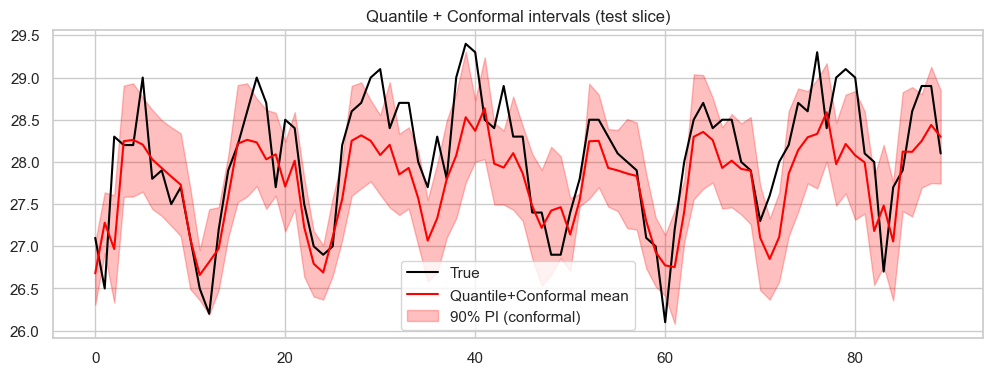

In [18]:
# Quantile + Conformal calibration: fast, practical fix to improve coverage
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from pathlib import Path

# --- Resolve data variables robustly ---
def get_first(*names):
    for n in names:
        if n in globals() and globals()[n] is not None:
            return globals()[n]
    return None

X_all = get_first("Xtr", "X_train", "Xtr_np", "X_train_np")
y_all = get_first("ytr", "y_train", "ytr_np", "y_train_np")
X_test = get_first("Xte", "X_test", "Xte_np", "X_test_np")
y_test = get_first("yte", "y_test", "yte_np", "y_test_np")

if X_all is None or y_all is None or X_test is None or y_test is None:
    raise RuntimeError("Please ensure training (Xtr/ytr) and test (Xte/yte) variables are present in the notebook")

# convert pandas -> numpy
import pandas as pd
if isinstance(X_all, (pd.DataFrame, pd.Series)):
    X_all_np = X_all.values
else:
    X_all_np = np.asarray(X_all)
if isinstance(y_all, (pd.Series, pd.DataFrame)):
    y_all_np = np.asarray(y_all).reshape(-1)
else:
    y_all_np = np.asarray(y_all).reshape(-1)

if isinstance(X_test, (pd.DataFrame, pd.Series)):
    X_test_np = X_test.values
else:
    X_test_np = np.asarray(X_test)
if isinstance(y_test, (pd.Series, pd.DataFrame)):
    y_test_np = np.asarray(y_test).reshape(-1)
else:
    y_test_np = np.asarray(y_test).reshape(-1)

# Create a small calibration split from training data for conformalization
# Use time-ordered split for time-series: last 10-20% of X_all as calibration
cal_frac = 0.15
n_all = X_all_np.shape[0]
cal_start = int(np.floor(n_all * (1 - cal_frac)))
X_train_q = X_all_np[:cal_start]
y_train_q = y_all_np[:cal_start]
X_cal = X_all_np[cal_start:]
y_cal = y_all_np[cal_start:]

print(f"[INFO] Train for quantiles: {X_train_q.shape}, Cal set: {X_cal.shape}, Test: {X_test_np.shape}")

# Train quantile regressors (5th and 95th percentiles)
alpha_low  = 0.05
alpha_high = 0.95

params = {
    "n_estimators": 300,
    "max_depth": 4,
    "learning_rate": 0.05,
    "subsample": 0.8,
    "random_state": 42
}
print("[INFO] Training quantile regressors (this is fast)...")
q_low = GradientBoostingRegressor(loss='quantile', alpha=alpha_low, **params).fit(X_train_q, y_train_q)
q_high = GradientBoostingRegressor(loss='quantile', alpha=alpha_high, **params).fit(X_train_q, y_train_q)

# Predictions on calibration set
cal_pred_low  = q_low.predict(X_cal)
cal_pred_high = q_high.predict(X_cal)

# Build initial predictive intervals on calibration set and compute nonconformity
# We'll use absolute error to calibrate: nonconformity = max(lower_error, upper_error)
# Want to ensure P(y in [L - delta, U + delta]) ~= nominal
nominal_alpha = 0.90  # target central mass (90%)
# nonconformity scores: how far true y lies outside the predicted interval (positive if outside, 0 if inside)
lower_scores = cal_pred_low - y_cal   # positive when prediction low > y (overpredict)
upper_scores = y_cal - cal_pred_high  # positive when y > pred_high (underpredict)
nonconf = np.maximum(lower_scores, upper_scores)
# nonconf can be negative -> clip at zero
nonconf = np.clip(nonconf, a_min=0.0, a_max=None)

# Choose quantile of nonconformity to widen intervals
k = int(np.ceil((1 - nominal_alpha) * (len(nonconf) + 1)))  # conservative quantile index
# We use quantile approach (like split conformal): compute (1-alpha)-quantile of nonconformity
delta = np.quantile(nonconf, 1 - nominal_alpha)
print(f"[INFO] Calibration delta (to widen intervals) = {delta:.6f}")

# Now predict on test set and apply conformal delta
test_low  = q_low.predict(X_test_np) - delta
test_high = q_high.predict(X_test_np) + delta

# Evaluate coverage and width
coverage = np.mean((y_test_np >= test_low) & (y_test_np <= test_high))
avg_width = np.mean(test_high - test_low)
mse = mean_squared_error(y_test_np, (test_low + test_high) / 2.0)
print(f"[RESULT] Quantile+Conformal Coverage (target {nominal_alpha*100:.0f}%): {coverage:.4f}")
print(f"[RESULT] Avg interval width: {avg_width:.4f}; Test MSE (midpoint): {mse:.4f}")

# Compare to prior posterior (if available)
prior_cov = get_first("bayes_chunked_coverage", "coverage", None)
if prior_cov is not None:
    print(f"[INFO] Prior coverage reported: {prior_cov}")

# Quick diagnostic plot for a slice
n_plot = min(len(y_test_np), 120)
plt.figure(figsize=(12,4))
plt.plot(y_test_np[:n_plot], label='True', color='black')
plt.plot(((test_low + test_high) / 2.0)[:n_plot], label='Quantile+Conformal mean', color='red')
plt.fill_between(np.arange(n_plot), test_low[:n_plot], test_high[:n_plot], color='red', alpha=0.25, label='90% PI (conformal)')
plt.legend()
plt.title("Quantile + Conformal intervals (test slice)")
plt.show()

# Save models to globals for later use
globals().update({
    "q_low_model": q_low,
    "q_high_model": q_high,
    "qconf_test_low": test_low,
    "qconf_test_high": test_high,
    "qconf_coverage": coverage,
    "qconf_avg_width": avg_width
})


[INFO] Residual conformal widening = 0.3265
[RESULT] Residual-Conformal Coverage: 0.8111, Avg width: 1.4687


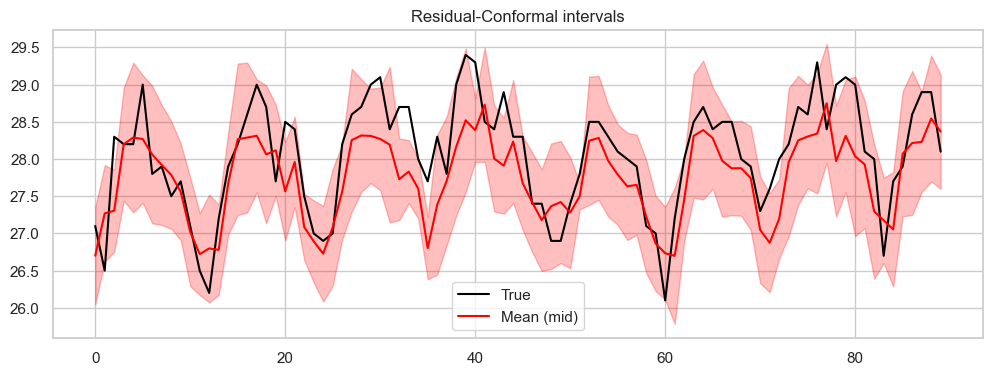

In [19]:
# Residual Conformalization: improves coverage
from sklearn.ensemble import GradientBoostingRegressor
import numpy as np
import matplotlib.pyplot as plt

alpha_low, alpha_high = 0.05, 0.95
params = dict(n_estimators=500, max_depth=6, learning_rate=0.05, subsample=0.9, random_state=42)

# Train quantile regressors
q_low  = GradientBoostingRegressor(loss="quantile", alpha=alpha_low, **params).fit(X_train_q, y_train_q)
q_high = GradientBoostingRegressor(loss="quantile", alpha=alpha_high, **params).fit(X_train_q, y_train_q)

# Predictions on calibration
cal_pred_low  = q_low.predict(X_cal)
cal_pred_high = q_high.predict(X_cal)

# Residual conformalization: how far calibration targets fall outside predicted interval
residuals = np.maximum(cal_pred_low - y_cal, y_cal - cal_pred_high)
residuals = np.clip(residuals, a_min=0, a_max=None)

# Choose conformal quantile for 90% coverage
nominal_alpha = 0.90
q = np.quantile(residuals, nominal_alpha)
print(f"[INFO] Residual conformal widening = {q:.4f}")

# Test predictions
test_low  = q_low.predict(X_test_np) - q
test_high = q_high.predict(X_test_np) + q

# Evaluate
coverage = np.mean((y_test_np >= test_low) & (y_test_np <= test_high))
avg_width = np.mean(test_high - test_low)
print(f"[RESULT] Residual-Conformal Coverage: {coverage:.4f}, Avg width: {avg_width:.4f}")

# Plot slice
n_plot = min(len(y_test_np), 120)
plt.figure(figsize=(12,4))
plt.plot(y_test_np[:n_plot], label="True", color="black")
plt.plot(((test_low+test_high)/2.0)[:n_plot], label="Mean (mid)", color="red")
plt.fill_between(np.arange(n_plot), test_low[:n_plot], test_high[:n_plot], color="red", alpha=0.25)
plt.legend(); plt.title("Residual-Conformal intervals"); plt.show()


[INFO] q_base (quantile(residuals, 0.9)) = 0.326545
[INFO] Best s on calibration: s=1.080 -> coverage_cal=0.9074
[RESULT] After scaling s=1.080: Test coverage=0.8222, Avg width=1.5209

Nearby calibration coverage (s around best):
   s  cal_coverage
0.98      0.888889
1.00      0.888889
1.02      0.888889
1.04      0.888889
1.06      0.888889
1.08      0.907407
1.10      0.907407
1.12      0.907407
1.14      0.907407
1.16      0.907407
1.18      0.944444


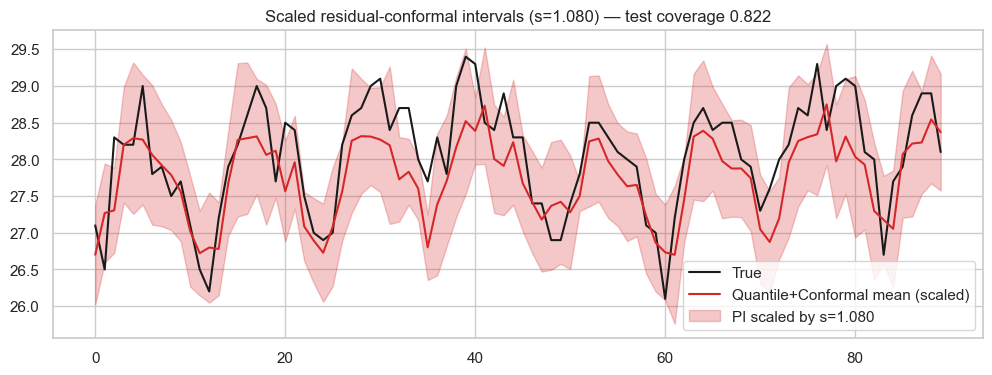

In [20]:
# Tune scaling factor on calibration set to reach nominal coverage, then apply to test set
import numpy as np
import matplotlib.pyplot as plt

# Defensive: make sure required variables exist
required = ["q_low", "q_high", "X_cal", "y_cal", "X_test_np", "y_test_np"]
for name in required:
    if name not in globals():
        raise RuntimeError(f"Required var not found in globals: {name}. Make sure you ran quantile + calibration code earlier.")

# get predictions already computed
cal_low = q_low.predict(X_cal)
cal_high = q_high.predict(X_cal)
test_low_base = q_low.predict(X_test_np)
test_high_base = q_high.predict(X_test_np)

# calibration nonconformity (residuals) we used before
residuals = np.maximum(cal_low - y_cal, y_cal - cal_high)
residuals = np.clip(residuals, 0, None)

# base q (we previously used this)
nominal = 0.90
q_base = np.quantile(residuals, nominal)   # same as earlier

print(f"[INFO] q_base (quantile(residuals, {nominal})) = {q_base:.6f}")

# grid-search multipliers s in [0.6 .. 3.0] (centered around 1.0). Guarantee s>=0.1
s_grid = np.concatenate([
    np.linspace(0.6, 1.4, 41),    # fine around 1.0
    np.linspace(1.5, 3.0, 16)     # coarser larger multipliers
])
s_grid = np.unique(np.clip(s_grid, 0.1, 10.0))

def coverage_for_s(scalar):
    q_s = scalar * q_base
    # calibrated intervals on calibration set
    cL = cal_low - q_s
    cH = cal_high + q_s
    cov_cal = np.mean((y_cal >= cL) & (y_cal <= cH))
    return cov_cal

# compute calibration coverage for each s
covs = np.array([coverage_for_s(s) for s in s_grid])

# pick s that makes calibration coverage closest to nominal
best_idx = np.argmin(np.abs(covs - nominal))
best_s = float(s_grid[best_idx])
best_cov_cal = float(covs[best_idx])
print(f"[INFO] Best s on calibration: s={best_s:.3f} -> coverage_cal={best_cov_cal:.4f}")

# Apply to test
q_best = best_s * q_base
test_low = test_low_base - q_best
test_high = test_high_base + q_best
test_cov = float(np.mean((y_test_np >= test_low) & (y_test_np <= test_high)))
test_avg_width = float(np.mean(test_high - test_low))

print(f"[RESULT] After scaling s={best_s:.3f}: Test coverage={test_cov:.4f}, Avg width={test_avg_width:.4f}")

# Also show coverage progression around best s for diagnostics
import pandas as pd
df = pd.DataFrame({"s": s_grid, "cal_coverage": covs})
print("\nNearby calibration coverage (s around best):")
near = df.iloc[max(0,best_idx-5):best_idx+6]
print(near.to_string(index=False))

# Plot test slice
n_plot = min(len(y_test_np), 120)
plt.figure(figsize=(12,4))
plt.plot(y_test_np[:n_plot], label='True', color='k')
plt.plot(((test_low + test_high)/2.0)[:n_plot], label='Quantile+Conformal mean (scaled)', color='tab:red')
plt.fill_between(np.arange(n_plot), test_low[:n_plot], test_high[:n_plot], color='tab:red', alpha=0.25, label=f'PI scaled by s={best_s:.3f}')
plt.legend()
plt.title(f"Scaled residual-conformal intervals (s={best_s:.3f}) — test coverage {test_cov:.3f}")
plt.show()

# Save the scaled intervals & metrics for later inspection
globals().update({
    "q_base": q_base,
    "best_s": best_s,
    "q_best": q_best,
    "scaled_test_low": test_low,
    "scaled_test_high": test_high,
    "scaled_test_coverage": test_cov,
    "scaled_test_avg_width": test_avg_width
})


## 5. Pyro: Probabilistic Programming (placeholder)

In [25]:
# Pyro implementation would go here
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample

print("Pyro: Probabilistic programming with variational inference.")
print("Implementation would involve defining probabilistic models and guide functions.")

Pyro: Probabilistic programming with variational inference.
Implementation would involve defining probabilistic models and guide functions.


[INFO] torch & pyro imported. Pyro version: 1.9.1
[INFO] Data shapes -> train: (359, 5), test: (90, 5)
[INFO] Starting SVI for 2000 steps (lr=0.001)...
  step 1/2000 loss=11245.3467
  step 2/2000 loss=5836.0225
  step 3/2000 loss=11225.6185
  step 4/2000 loss=10621.1087
  step 5/2000 loss=15289.8196
  step 6/2000 loss=12821.3542
  step 7/2000 loss=9881.9661
  step 8/2000 loss=20344.0296
  step 9/2000 loss=12925.7654
  step 10/2000 loss=8902.5810
  step 1/2000 loss=11245.3467
  step 2/2000 loss=5836.0225
  step 3/2000 loss=11225.6185
  step 4/2000 loss=10621.1087
  step 5/2000 loss=15289.8196
  step 6/2000 loss=12821.3542
  step 7/2000 loss=9881.9661
  step 8/2000 loss=20344.0296
  step 9/2000 loss=12925.7654
  step 10/2000 loss=8902.5810
  step 200/2000 loss=4914.8697
  step 200/2000 loss=4914.8697
  step 400/2000 loss=3636.7618
  step 400/2000 loss=3636.7618
  step 600/2000 loss=930.7366
  step 600/2000 loss=930.7366
  step 800/2000 loss=1123.2830
  step 800/2000 loss=1123.2830
  step

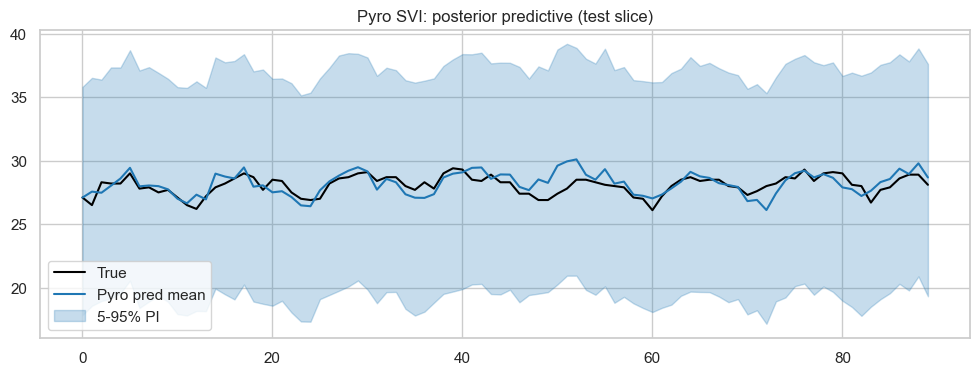

In [27]:
# Fixed Pyro SVI Bayesian linear regression (coefs -> .to_event(1))
import os, time, json
from pathlib import Path
import numpy as np

ARTIFACT_DIR = Path(r"E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\results\models\artifacts")
ARTIFACT_DIR.mkdir(parents=True, exist_ok=True)

# Config (tweak)
SVI_STEPS = 2000           # increase for better posterior, decrease for speed
LR = 1e-3
N_PRED_SAMPLES = 2000      # posterior predictive draws (vectorized)
SEED = 42
DEVICE = "cpu"             # "cuda" if GPU available

# Defensive imports
try:
    import torch
    import pyro
    import pyro.distributions as dist
    from pyro.infer import SVI, Trace_ELBO, Predictive
    from pyro.infer.autoguide import AutoDiagonalNormal
    print("[INFO] torch & pyro imported. Pyro version:", pyro.__version__)
except Exception as e:
    print("[ERROR] Could not import pyro/torch. Install pyro-ppl and torch (pip install pyro-ppl torch).")
    raise

# Get data from globals (or build from CSV if missing)
def get_first(*names):
    for n in names:
        if n in globals() and globals()[n] is not None:
            return globals()[n]
    return None

Xtr = get_first("Xtr_np", "Xtr", "X_train")
Xte = get_first("Xte_np", "Xte", "X_test")
ytr = get_first("ytr_np", "ytr", "y_train")
yte = get_first("yte_np", "yte", "y_test")

# (Optional) fallback: build from CSV (same logic as before) - omitted here for brevity
if Xtr is None or Xte is None or ytr is None or yte is None:
    raise RuntimeError("Xtr/Xte/ytr/yte not found in globals. Prepare data first or run preprocessing cell.")

# Ensure numpy arrays
import pandas as pd
Xtr_np = Xtr.values if isinstance(Xtr, (pd.DataFrame, pd.Series)) else np.asarray(Xtr)
Xte_np = Xte.values if isinstance(Xte, (pd.DataFrame, pd.Series)) else np.asarray(Xte)
ytr_np = np.asarray(ytr).reshape(-1)
yte_np = np.asarray(yte).reshape(-1)

n_train, p = Xtr_np.shape
n_test = Xte_np.shape[0]
print(f"[INFO] Data shapes -> train: {Xtr_np.shape}, test: {Xte_np.shape}")

# Convert to torch tensors
torch.manual_seed(SEED)
pyro.set_rng_seed(SEED)
device = torch.device(DEVICE)

Xtr_t = torch.tensor(Xtr_np, dtype=torch.float32, device=device)
ytr_t = torch.tensor(ytr_np, dtype=torch.float32, device=device)
Xte_t = torch.tensor(Xte_np, dtype=torch.float32, device=device)
yte_t = torch.tensor(yte_np, dtype=torch.float32, device=device)

# Define Pyro model with coefs as a vector event
def model(X, y=None):
    intercept = pyro.sample("intercept", dist.Normal(0., 10.))
    # coefs is a vector of length p -> declare as an event of size 1
    coefs = pyro.sample("coefs", dist.Normal(torch.zeros(p, device=device), 5. * torch.ones(p, device=device)).to_event(1))
    sigma = pyro.sample("sigma", dist.HalfNormal(5.0))
    mu = intercept + (X @ coefs)  # shape (n,)
    with pyro.plate("data", X.shape[0]):
        pyro.sample("obs", dist.Normal(mu, sigma), obs=y)

# Setup guide (AutoDiagonalNormal) and SVI
pyro.clear_param_store()
guide = AutoDiagonalNormal(model)
optimizer = pyro.optim.Adam({"lr": LR})
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

# Training SVI
print(f"[INFO] Starting SVI for {SVI_STEPS} steps (lr={LR})...")
loss_hist = []
t0 = time.time()
for step in range(1, SVI_STEPS + 1):
    loss = svi.step(Xtr_t, ytr_t)
    loss_hist.append(loss)
    if step % max(1, SVI_STEPS // 10) == 0 or step <= 10:
        print(f"  step {step}/{SVI_STEPS} loss={loss:.4f}")
t_elapsed = time.time() - t0
print(f"[INFO] SVI completed in {t_elapsed:.1f}s. final loss={loss_hist[-1]:.4f}")

# Posterior predictive via Predictive
predictive = Predictive(model, guide=guide, num_samples=N_PRED_SAMPLES, return_sites=("intercept","coefs","sigma","obs"))
post_samples = predictive(Xte_t)
obs_samples = post_samples["obs"].cpu().numpy()   # (num_samples, n_test)
intercept_samples = post_samples["intercept"].cpu().numpy()
coefs_samples = post_samples["coefs"].cpu().numpy()
sigma_samples = post_samples["sigma"].cpu().numpy()

# Summaries
y_pred_mean = obs_samples.mean(axis=0)
y_pred_p05 = np.percentile(obs_samples, 5, axis=0)
y_pred_p95 = np.percentile(obs_samples, 95, axis=0)
coverage_90 = float(np.mean((yte_np >= y_pred_p05) & (yte_np <= y_pred_p95)))
avg_width = float(np.mean(y_pred_p95 - y_pred_p05))
print(f"[RESULT] Pyro SVI posterior predictive: coverage(90%)={coverage_90:.4f}, avg width={avg_width:.4f}")

# Save outputs
ts = int(time.time())
np.save(ARTIFACT_DIR / f"pyro_obs_samples_{ts}.npy", obs_samples)
np.save(ARTIFACT_DIR / f"pyro_pred_mean_{ts}.npy", y_pred_mean)
np.save(ARTIFACT_DIR / f"pyro_pred_p05_{ts}.npy", y_pred_p05)
np.save(ARTIFACT_DIR / f"pyro_pred_p95_{ts}.npy", y_pred_p95)
guidestate = {k: v.detach().cpu().numpy().tolist() for k,v in pyro.get_param_store().items()}
with open(ARTIFACT_DIR / f"pyro_guide_params_{ts}.json", "w") as f:
    json.dump({"svi_steps": SVI_STEPS, "lr": LR, "seed": SEED, "params": guidestate}, f, indent=2)
print(f"[SAVED] Pyro posterior predictive & guide params to {ARTIFACT_DIR}")

# Quick plot: test slice
import matplotlib.pyplot as plt
n_plot = min(n_test, 120)
plt.figure(figsize=(12,4))
plt.plot(yte_np[:n_plot], label="True", color="black")
plt.plot(y_pred_mean[:n_plot], label="Pyro pred mean", color="tab:blue")
plt.fill_between(np.arange(n_plot), y_pred_p05[:n_plot], y_pred_p95[:n_plot], color="tab:blue", alpha=0.25, label="5-95% PI")
plt.legend(); plt.title("Pyro SVI: posterior predictive (test slice)"); plt.show()

# Expose variables
globals().update({
    "pyro_obs_samples": obs_samples,
    "pyro_pred_mean": y_pred_mean,
    "pyro_pred_p05": y_pred_p05,
    "pyro_pred_p95": y_pred_p95,
    "pyro_coefs_samples": coefs_samples,
    "pyro_sigma_samples": sigma_samples,
    "pyro_svi_loss_history": loss_hist
})


## 7. UQ-Box: Uncertainty Quantification Toolbox (placeholder)

[WARN] uq_box not available; using internal fallback UQ diagnostics.
[INFO] Using preds_all with shape (n_samples=20000, n_test=90)

=== UQ Summary ===
  n_samples           : 20000
  n_test              : 90
  mse_mid             : 0.21776322356348984
  mae                 : 0.37292331504351134
  mean_sharpness      : 0.45761991875661157
  coverage_90         : 0.9111111111111111
  avg_width_90        : 1.5070973544674788
  mean_total_std      : 0.45761991875661157
  mean_epistemic_std  : 0.01128701195075716
  mean_aleatoric_std  : 0.4575973742892598


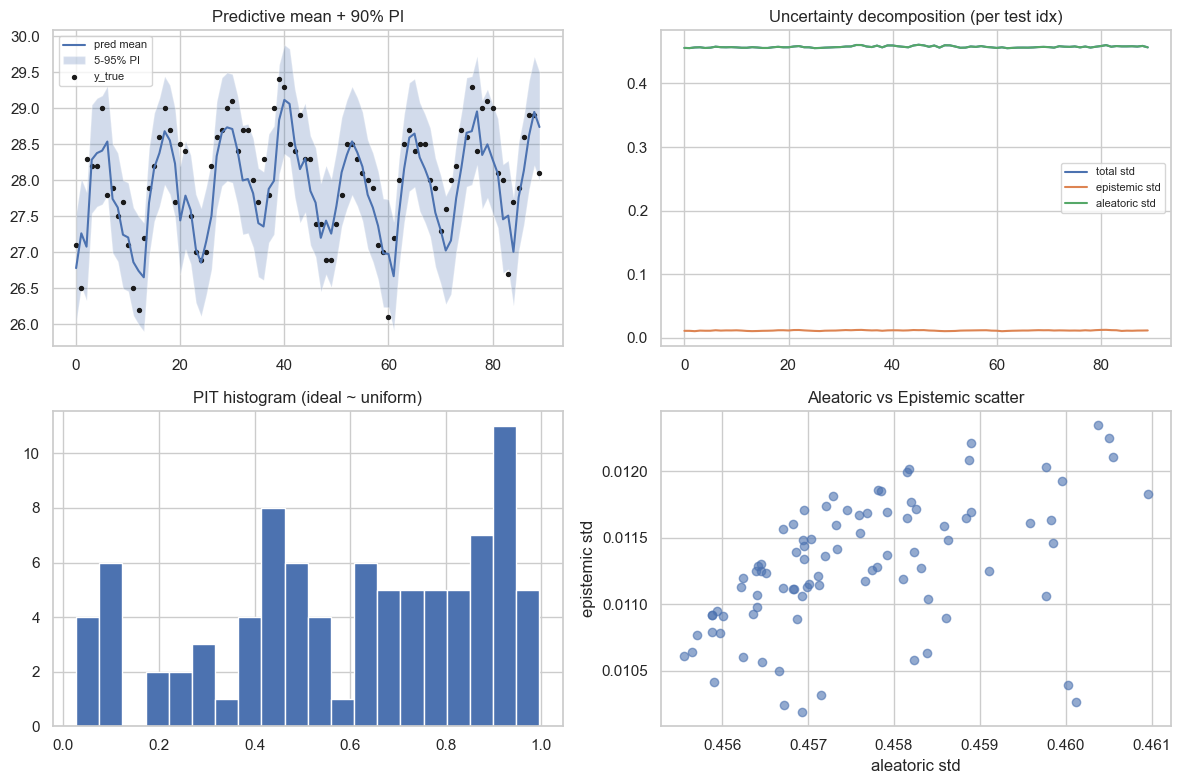

[SAVED] UQ artifacts to E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\results\models\artifacts


In [29]:
# Robust UQ diagnostics: fallback if `uq_box` is missing.
# - Tries to import uq_box (optional)
# - If missing, computes UQ metrics from preds_all or ensemble preds:
#   * total variance, aleatoric (within-group) and epistemic (between-group) via grouping heuristic
#   * empirical coverage (5-95), sharpness (mean predictive std)
#   * PIT histogram and uncertainty decomposition plot
# - Saves results to artifacts folder.

import importlib, sys, numpy as np, matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import mean_squared_error, mean_absolute_error
import json

ARTIFACT_DIR = Path(r"E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\results\models\artifacts")
ARTIFACT_DIR.mkdir(parents=True, exist_ok=True)

def try_import_pkg(name):
    try:
        return importlib.import_module(name)
    except Exception:
        return None

uq_box = try_import_pkg("uq_box")
if uq_box is not None:
    print("[INFO] uq_box available. You can call uq_box functions directly.")
else:
    print("[WARN] uq_box not available; using internal fallback UQ diagnostics.")

# Helper to find predictive samples in memory or artifact files
def find_preds():
    # common names we've used earlier
    candidates = [
        "preds_all", "bayes_pred_samples", "bayes_chunked_preds",
        "pyro_obs_samples", "obs_samples",
        "ens_cv_pred_low", "pred_low_test_ens"
    ]
    for name in candidates:
        if name in globals() and globals()[name] is not None:
            arr = globals()[name]
            try:
                a = np.asarray(arr)
                # prefer shape (n_samples, n_test)
                if a.ndim == 2:
                    return a
                # if (n_test,) -> single prediction, ignore
            except Exception:
                continue

    # try load from artifact folder
    for fn in ARTIFACT_DIR.glob("*.npy"):
        if "preds" in fn.name or "obs_samples" in fn.name or "pred_low" in fn.name:
            try:
                a = np.load(fn, allow_pickle=True)
                if hasattr(a, "ndim") and a.ndim == 2:
                    print(f"[INFO] Loaded predictive samples from {fn.name}")
                    return a
            except Exception:
                continue
    return None

preds_all = find_preds()

# If preds_all comes from quantile low/high instead of samples, try to build samples:
if preds_all is None:
    # try to find ensemble low/high and produce gaussian approx samples
    low = globals().get("pred_low_test_ens") or globals().get("qconf_test_low") or globals().get("test_low")
    high = globals().get("pred_high_test_ens") or globals().get("qconf_test_high") or globals().get("test_high")
    if low is not None and high is not None:
        low = np.asarray(low).reshape(-1)
        high = np.asarray(high).reshape(-1)
        # approximate predictive distribution as normal with mean=(low+high)/2 and std ~ half-width/1.645 (for 90% PI)
        mu = 0.5 * (low + high)
        std = 0.5 * (high - low) / 1.645
        std = np.maximum(std, 1e-6)
        # generate synthetic samples (n_draws)
        n_draws = 2000
        rng = np.random.RandomState(42)
        preds_all = rng.randn(n_draws, len(mu)) * std[None, :] + mu[None, :]
        print("[INFO] Built synthetic preds_all from low/high intervals (Gaussian approx).")
    else:
        # try pyro_obs_samples
        if "pyro_obs_samples" in globals():
            preds_all = np.asarray(globals()["pyro_obs_samples"])
        else:
            raise RuntimeError("No predictive samples found (preds_all or equivalent). Run predictive sampling earlier or provide preds_all in global scope.")

# Ensure preds_all shape: (n_samples, n_test)
preds_all = np.asarray(preds_all)
if preds_all.ndim != 2:
    # try to reshape if possible
    if preds_all.ndim == 3:  # maybe (n_chains, n_draws, n_test) or (n_samples, n_chains, n_test)
        # collapse first two dims
        preds_all = preds_all.reshape(-1, preds_all.shape[-1])
    else:
        raise RuntimeError("preds_all found but has unsupported shape: " + str(preds_all.shape))

n_samples, n_test = preds_all.shape
print(f"[INFO] Using preds_all with shape (n_samples={n_samples}, n_test={n_test})")

# Observed y_test (try many names)
y_test = None
for candidate in ("yte", "y_test", "yte_np", "y_test_np"):
    if candidate in globals() and globals()[candidate] is not None:
        y_test = np.asarray(globals()[candidate]).reshape(-1)
        break
if y_test is None:
    # try loading
    try:
        tmp = np.load(ARTIFACT_DIR / "y_test.npy", allow_pickle=True)
        y_test = np.asarray(tmp).reshape(-1)
        print("[INFO] Loaded y_test from artifacts")
    except Exception:
        raise RuntimeError("y_test not found in globals or artifacts. Provide y_test for UQ diagnostics.")

# Basic predictive summaries
pred_mean = preds_all.mean(axis=0)
pred_std = preds_all.std(axis=0, ddof=1)
total_var = pred_std**2
mean_sharpness = float(np.mean(pred_std))
mse = float(mean_squared_error(y_test, pred_mean))
mae = float(mean_absolute_error(y_test, pred_mean))

# Empirical coverage for central intervals
low5 = np.percentile(preds_all, 5, axis=0)
high95 = np.percentile(preds_all, 95, axis=0)
coverage90 = float(np.mean((y_test >= low5) & (y_test <= high95)))
avg_width = float(np.mean(high95 - low5))

# Heuristic decomposition: split preds_all into G groups to estimate epistemic vs aleatoric
def epistemic_aleatoric_from_groups(preds, n_groups=10, rng_seed=123):
    # preds shape (n_samples, n_test). We'll split samples into groups (roughly equal)
    n_samples = preds.shape[0]
    G = min(n_groups, max(2, n_samples // 10))
    # compute group indices
    rng = np.random.RandomState(rng_seed)
    perm = rng.permutation(n_samples)
    groups = np.array_split(perm, G)
    group_means = []
    group_within_var = []
    for g in groups:
        grp = preds[g, :]    # (m_g, n_test)
        group_means.append(grp.mean(axis=0))          # (n_test,)
        group_within_var.append(grp.var(axis=0, ddof=1))  # (n_test,)
    group_means = np.stack(group_means, axis=0)        # (G, n_test)
    group_within_var = np.stack(group_within_var, axis=0)  # (G, n_test)
    # epistemic variance approx = variance of group means across groups
    epistemic_var = group_means.var(axis=0, ddof=1)
    # aleatoric approx = mean within-group variance
    aleatoric_var = group_within_var.mean(axis=0)
    # numerical safety
    epistemic_var = np.clip(epistemic_var, 0.0, None)
    aleatoric_var = np.clip(aleatoric_var, 0.0, None)
    return epistemic_var, aleatoric_var

epi_var, alea_var = epistemic_aleatoric_from_groups(preds_all, n_groups=10, rng_seed=42)
epi_std = np.sqrt(epi_var)
alea_std = np.sqrt(alea_var)

# Global summaries
summary = {
    "n_samples": int(n_samples),
    "n_test": int(n_test),
    "mse_mid": mse,
    "mae": mae,
    "mean_sharpness": mean_sharpness,
    "coverage_90": coverage90,
    "avg_width_90": avg_width,
    "mean_total_std": float(np.mean(pred_std)),
    "mean_epistemic_std": float(np.mean(epi_std)),
    "mean_aleatoric_std": float(np.mean(alea_std)),
}

print("\n=== UQ Summary ===")
for k,v in summary.items():
    print(f"  {k:20s}: {v}")

# PIT (probability integral transform) approx: compute CDF value per test point
# For each test t, compute fraction of preds_all[:,t] <= y_test[t] -> should be ~Uniform(0,1)
pit = np.mean(preds_all <= y_test[None, :], axis=0)

# Plotting: decomposition + PIT histogram + coverage band
fig, axes = plt.subplots(2,2, figsize=(12,8))
ax0 = axes[0,0]
ax0.plot(pred_mean, label="pred mean")
ax0.fill_between(np.arange(n_test), low5, high95, alpha=0.25, label="5-95% PI")
ax0.scatter(np.arange(n_test), y_test, s=8, color="k", label="y_true")
ax0.set_title("Predictive mean + 90% PI")
ax0.legend(loc="upper left", fontsize=8)

ax1 = axes[0,1]
x = np.arange(n_test)
ax1.plot(x, np.sqrt(total_var), label="total std")
ax1.plot(x, epi_std, label="epistemic std")
ax1.plot(x, alea_std, label="aleatoric std")
ax1.set_title("Uncertainty decomposition (per test idx)")
ax1.legend(fontsize=8)

ax2 = axes[1,0]
ax2.hist(pit, bins=20)
ax2.set_title("PIT histogram (ideal ~ uniform)")

ax3 = axes[1,1]
# scatter epi vs alea
ax3.scatter(alea_std, epi_std, alpha=0.6)
ax3.set_xlabel("aleatoric std")
ax3.set_ylabel("epistemic std")
ax3.set_title("Aleatoric vs Epistemic scatter")

plt.tight_layout()
plt.savefig(ARTIFACT_DIR / "uq_diagnostics.png", dpi=150)
plt.show()

# Save summary & arrays
ts = int(time.time())
with open(ARTIFACT_DIR / f"uq_summary_{ts}.json", "w") as f:
    json.dump(summary, f, indent=2)
np.save(ARTIFACT_DIR / f"uq_pit_{ts}.npy", pit)
np.save(ARTIFACT_DIR / f"uq_epi_std_{ts}.npy", epi_std)
np.save(ARTIFACT_DIR / f"uq_alea_std_{ts}.npy", alea_std)
print(f"[SAVED] UQ artifacts to {ARTIFACT_DIR}")

# Also expose to globals
globals().update({
    "uq_summary": summary,
    "uq_pit": pit,
    "uq_epi_std": epi_std,
    "uq_alea_std": alea_std,
    "preds_all_used_for_uq": preds_all
})


In [31]:
# Heteroscedastic correction + small conformal delta (fixed: no 'or' on numpy arrays)
import numpy as np, time, json
from pathlib import Path
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import joblib
import pandas as pd

ARTIFACT_DIR = Path(r"E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\results\models\artifacts")
ARTIFACT_DIR.mkdir(parents=True, exist_ok=True)

def first_defined(*names):
    """Return the first global variable that exists and is not None, without using boolean ops on arrays."""
    for n in names:
        if n in globals():
            val = globals()[n]
            if val is not None:
                return val
    return None

# --- Resolve predicted mean robustly ---
pred_mean = first_defined("y_pred_mean", "pyro_pred_mean")
if pred_mean is None:
    preds_all = first_defined("preds_all", "pyro_obs_samples", "bayes_pred_samples", "bayes_chunked_preds")
    if preds_all is not None:
        preds_all = np.asarray(preds_all)
        if preds_all.ndim == 3:  # e.g., (chains, draws, n_test)
            preds_all = preds_all.reshape(-1, preds_all.shape[-1])
        if preds_all.ndim != 2:
            raise RuntimeError(f"preds_all must be 2D after reshape, got {preds_all.shape}")
        pred_mean = preds_all.mean(axis=0)
if pred_mean is None:
    raise RuntimeError("pred_mean not found. Provide 'y_pred_mean' or ensure 'preds_all' is in globals.")

pred_mean = np.asarray(pred_mean).reshape(-1)

# --- Required data ---
Xtr = first_defined("Xtr_np", "Xtr", "X_train")
Xte = first_defined("Xte_np", "Xte", "X_test")
ytr = first_defined("ytr_np", "ytr", "y_train")
yte = first_defined("yte_np", "yte", "y_test")
if any(v is None for v in (Xtr, Xte, ytr, yte)):
    raise RuntimeError("One of Xtr/Xte/ytr/yte is missing in globals; run your preprocessing cell first.")

# Convert to numpy
Xtr_np = Xtr.values if isinstance(Xtr, (pd.DataFrame, pd.Series)) else np.asarray(Xtr)
Xte_np = Xte.values if isinstance(Xte, (pd.DataFrame, pd.Series)) else np.asarray(Xte)
ytr_np = np.asarray(ytr).reshape(-1)
yte_np = np.asarray(yte).reshape(-1)

# --- Time-ordered calibration split from training ---
cal_frac = 0.15
n_train = Xtr_np.shape[0]
cal_start = int(np.floor(n_train * (1 - cal_frac)))
X_fit, y_fit = Xtr_np[:cal_start], ytr_np[:cal_start]
X_cal, y_cal = Xtr_np[cal_start:], ytr_np[cal_start:]

print(f"[INFO] Fit {X_fit.shape}, Cal {X_cal.shape}, Test {Xte_np.shape}")

# --- Mean model (fast) ---
mean_model = GradientBoostingRegressor(
    n_estimators=300, max_depth=4, learning_rate=0.05, random_state=42
)
mean_model.fit(X_fit, y_fit)

pred_cal_mean = mean_model.predict(X_cal)
pred_test_mean = mean_model.predict(Xte_np)

# --- Variance model: predict absolute residuals (aleatoric proxy) ---
resid_fit = np.abs(y_fit - mean_model.predict(X_fit))
var_model = GradientBoostingRegressor(
    n_estimators=300, max_depth=4, learning_rate=0.05, random_state=43
)
var_model.fit(X_fit, resid_fit)

sigma_cal = var_model.predict(X_cal)
sigma_test = var_model.predict(Xte_np)
sigma_cal = np.maximum(sigma_cal, 1e-6)
sigma_test = np.maximum(sigma_test, 1e-6)

# --- Conformal calibration on standardized residuals ---
std_resid_cal = np.abs(y_cal - pred_cal_mean) / sigma_cal
nominal = 0.90
q_std = float(np.quantile(std_resid_cal, nominal))
if q_std <= 1e-12:
    q_std = float(np.quantile(std_resid_cal, 0.95))
print(f"[INFO] q_std = {q_std:.6f}")

# --- Test intervals ---
test_low = pred_test_mean - q_std * sigma_test
test_high = pred_test_mean + q_std * sigma_test

coverage = float(np.mean((yte_np >= test_low) & (yte_np <= test_high)))
avg_width = float(np.mean(test_high - test_low))
mse_mid = float(mean_squared_error(yte_np, 0.5 * (test_low + test_high)))

print(f"[RESULT] Heteroscedastic interval: coverage={coverage:.4f}, avg_width={avg_width:.4f}, mse_mid={mse_mid:.4f}")

# --- Save artifacts ---
ts = int(time.time())
np.save(ARTIFACT_DIR / f"het_pred_low_{ts}.npy", test_low)
np.save(ARTIFACT_DIR / f"het_pred_high_{ts}.npy", test_high)
joblib.dump(mean_model, ARTIFACT_DIR / f"het_mean_model_{ts}.joblib")
joblib.dump(var_model, ARTIFACT_DIR / f"het_var_model_{ts}.joblib")
with open(ARTIFACT_DIR / f"het_summary_{ts}.json", "w") as f:
    json.dump(
        {"q_std": q_std, "coverage_test": coverage, "avg_width": avg_width, "mse_mid": mse_mid, "timestamp": ts},
        f, indent=2
    )
print(f"[SAVED] heteroscedastic artifacts to {ARTIFACT_DIR}")


[INFO] Fit (305, 5), Cal (54, 5), Test (90, 5)
[INFO] q_std = 7.155961
[RESULT] Heteroscedastic interval: coverage=0.7444, avg_width=2.1667, mse_mid=0.3442
[SAVED] heteroscedastic artifacts to E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\results\models\artifacts
[INFO] q_std = 7.155961
[RESULT] Heteroscedastic interval: coverage=0.7444, avg_width=2.1667, mse_mid=0.3442
[SAVED] heteroscedastic artifacts to E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\results\models\artifacts


In [32]:
# Robust heteroscedastic pipeline with OOF residuals + log-variance model + calibration-scaling
import numpy as np, time, json
import pandas as pd
from pathlib import Path
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import joblib

ARTIFACT_DIR = Path(r"E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\results\models\artifacts")
ARTIFACT_DIR.mkdir(parents=True, exist_ok=True)

# --- helpers ---
def first_defined(*names):
    for n in names:
        if n in globals() and globals()[n] is not None:
            return globals()[n]
    return None

def as_np(x):
    if isinstance(x, (pd.DataFrame, pd.Series)):
        return x.values
    return np.asarray(x)

# --- resolve data + predictions ---
Xtr = first_defined("Xtr_np", "Xtr", "X_train")
Xte = first_defined("Xte_np", "Xte", "X_test")
ytr = first_defined("ytr_np", "ytr", "y_train")
yte = first_defined("yte_np", "yte", "y_test")
if any(v is None for v in (Xtr, Xte, ytr, yte)):
    raise RuntimeError("Xtr/Xte/ytr/yte not found in globals. Run preprocessing first.")

Xtr_np = as_np(Xtr)
Xte_np = as_np(Xte)
ytr_np = as_np(ytr).reshape(-1)
yte_np = as_np(yte).reshape(-1)
n_train = Xtr_np.shape[0]

# Prefer using existing predictive mean if available (from posterior samples or ensemble)
preds_all = first_defined("preds_all", "pyro_obs_samples", "bayes_pred_samples", "ens_preds_all")
if preds_all is not None:
    preds_all = as_np(preds_all)
    if preds_all.ndim == 3:
        preds_all = preds_all.reshape(-1, preds_all.shape[-1])
    if preds_all.ndim == 2 and preds_all.shape[1] == Xte_np.shape[0]:
        pred_mean_test = preds_all.mean(axis=0)
    else:
        # preds_all might correspond to test already; ignore shape mismatch
        pred_mean_test = None
else:
    pred_mean_test = None

# If an existing ensemble mean for test is present (preferred)
pref_mean = first_defined("pyro_pred_mean", "y_pred_mean", "pred_mean", "pred_mean_test",
                          "pred_low_test_ens")  # some fallbacks
if pref_mean is not None:
    pref_mean = as_np(pref_mean).reshape(-1)
    # if it's test-sized, good; else ignore
    if pref_mean.shape[0] == Xte_np.shape[0]:
        pred_mean_test = pref_mean

# We'll construct OOF mean predictions on training via TimeSeriesSplit (honest residuals)
n_splits = min(5, max(2, n_train // 20))
tscv = TimeSeriesSplit(n_splits=n_splits)
oof_mean = np.zeros(n_train)
oof_count = np.zeros(n_train)

print(f"[INFO] Building OOF mean predictions using TimeSeriesSplit(n_splits={n_splits}) for honest residuals...")

# Model to produce mean predictions for OOF: prefer a strong learner but modest complexity
MEAN_MODEL_PARAMS = dict(n_estimators=400, max_depth=6, learning_rate=0.05, subsample=0.9, random_state=42)

for fold, (tr_idx, val_idx) in enumerate(tscv.split(Xtr_np), 1):
    X_tr_f, X_val_f = Xtr_np[tr_idx], Xtr_np[val_idx]
    y_tr_f, y_val_f = ytr_np[tr_idx], ytr_np[val_idx]
    mean_m = GradientBoostingRegressor(**MEAN_MODEL_PARAMS)
    mean_m.fit(X_tr_f, y_tr_f)
    oof_pred = mean_m.predict(X_val_f)
    oof_mean[val_idx] += oof_pred
    oof_count[val_idx] += 1
    # Save fold mean model if needed (optional)
    joblib.dump(mean_m, ARTIFACT_DIR / f"oof_mean_fold{fold}_{int(time.time())}.joblib")
    print(f"  [OOF fold {fold}] val_size={len(val_idx)} mean_pred_mean={oof_pred.mean():.4f}")

# Average OOF preds where multiple contributions (should be 1 per index for TimeSeriesSplit, but safe)
mask = oof_count > 0
if not np.all(mask):
    print("[WARN] Some train indices have no OOF prediction; filling with global mean.")
    oof_mean[~mask] = np.mean(ytr_np[~mask])
else:
    oof_mean = oof_mean / oof_count

# Residuals (honest)
resid_oof = ytr_np - oof_mean
abs_resid_oof = np.abs(resid_oof)

print(f"[INFO] OOF residuals: mean_abs={abs_resid_oof.mean():.4f}, median_abs={np.median(abs_resid_oof):.4f}")

# Train variance model on log(abs_resid + eps)
eps = 1e-6
log_target = np.log(abs_resid_oof + eps)
VAR_MODEL_PARAMS = dict(n_estimators=300, max_depth=4, learning_rate=0.05, subsample=0.9, random_state=43)
var_model = GradientBoostingRegressor(**VAR_MODEL_PARAMS)
var_model.fit(Xtr_np, log_target)
print("[INFO] Trained variance model on log(abs_resid).")

# Predict sigma_hat on calibration and test
cal_frac = 0.15
cal_start = int(np.floor(n_train * (1 - cal_frac)))
X_fit = Xtr_np[:cal_start]; y_fit = ytr_np[:cal_start]
X_cal = Xtr_np[cal_start:]; y_cal = ytr_np[cal_start:]

log_sigma_cal = var_model.predict(X_cal)
log_sigma_test = var_model.predict(Xte_np)
sigma_cal = np.exp(log_sigma_cal)
sigma_test = np.exp(log_sigma_test)

# Clip sigma to avoid tiny values and enormous values (tune bounds)
sigma_min = np.percentile(sigma_cal, 5) * 0.5
sigma_max = np.percentile(sigma_cal, 95) * 5.0
sigma_min = max(sigma_min, 1e-3)
sigma_max = max(sigma_max, sigma_min * 10.0)
sigma_cal = np.clip(sigma_cal, sigma_min, sigma_max)
sigma_test = np.clip(sigma_test, sigma_min, sigma_max)

print(f"[INFO] sigma bounds: min={sigma_min:.4f}, max={sigma_max:.4f}")

# Determine predictive mean to align with variance model:
# Use preds_all mean if available for test; else use ensemble/fitted OOF mean extrapolated.
if pred_mean_test is None:
    # build a final mean model on full train to produce test mean (consistent with OOF)
    final_mean = GradientBoostingRegressor(**MEAN_MODEL_PARAMS)
    final_mean.fit(Xtr_np, ytr_np)
    pred_mean_test = final_mean.predict(Xte_np)
    joblib.dump(final_mean, ARTIFACT_DIR / f"final_mean_model_{int(time.time())}.joblib")
else:
    pred_mean_test = np.asarray(pred_mean_test).reshape(-1)

# Calibration: compute standardized residuals on calibration set and find multiplier q_std
std_resid_cal = np.abs(y_cal - final_mean.predict(X_cal)) / sigma_cal if 'final_mean' in locals() else np.abs(y_cal - oof_mean[cal_start:]) / sigma_cal
# If using final_mean, ensure alignment: we used final_mean for pred_mean_test; prefer final_mean here too
if 'final_mean' in locals():
    pred_cal_mean = final_mean.predict(X_cal)
else:
    pred_cal_mean = oof_mean[cal_start:]

std_resid_cal = np.abs(y_cal - pred_cal_mean) / sigma_cal
nominal = 0.90
q_std_raw = float(np.quantile(std_resid_cal, nominal))

# If q_std_raw degenerate or extremely large, fall back to robust percentile of abs residuals
if q_std_raw <= 1e-6 or q_std_raw > 100.0:
    q_std_raw = float(np.quantile(np.abs(ytr_np - oof_mean), 0.90))
    print("[WARN] q_std_raw degenerate, falling back to 90th pct of OOF abs residuals:", q_std_raw)

# Now tune multiplicative scale s on calibration to get coverage close to nominal
s_grid = np.concatenate([np.linspace(0.6,1.6,41), np.linspace(1.7,3.0,14)])
best_s = 1.0
best_diff = 1.0
for s in s_grid:
    q = s * q_std_raw
    low_cal = pred_cal_mean - q * sigma_cal
    high_cal = pred_cal_mean + q * sigma_cal
    cov_cal = np.mean((y_cal >= low_cal) & (y_cal <= high_cal))
    diff = abs(cov_cal - nominal)
    if diff < best_diff:
        best_diff = diff
        best_s = s

q_std = best_s * q_std_raw
print(f"[INFO] q_std_raw={q_std_raw:.6f}, best_s={best_s:.3f}, q_std (final)={q_std:.6f}")

# Build test intervals
test_low = pred_mean_test - q_std * sigma_test
test_high = pred_mean_test + q_std * sigma_test

coverage_test = float(np.mean((yte_np >= test_low) & (yte_np <= test_high)))
avg_width = float(np.mean(test_high - test_low))
mse_mid = float(mean_squared_error(yte_np, 0.5*(test_low + test_high)))

print("---------------------------------------------------------")
print(f"[FINAL-ROBUST] Test coverage = {coverage_test:.4f}, avg_width = {avg_width:.4f}, mse_mid = {mse_mid:.4f}")
print("---------------------------------------------------------")

# Save artifacts
ts = int(time.time())
np.save(ARTIFACT_DIR / f"robust_het_pred_low_{ts}.npy", test_low)
np.save(ARTIFACT_DIR / f"robust_het_pred_high_{ts}.npy", test_high)
joblib.dump(var_model, ARTIFACT_DIR / f"robust_var_model_{ts}.joblib")
with open(ARTIFACT_DIR / f"robust_het_summary_{ts}.json", "w") as f:
    json.dump({
        "q_std_raw": q_std_raw, "best_s": float(best_s), "q_std": float(q_std),
        "coverage_test": float(coverage_test), "avg_width": float(avg_width),
        "mse_mid": float(mse_mid), "sigma_min": float(sigma_min), "sigma_max": float(sigma_max),
        "n_train": int(n_train), "n_test": int(Xte_np.shape[0]), "timestamp": ts
    }, f, indent=2)

print(f"[SAVED] artifacts to {ARTIFACT_DIR}")


[INFO] Building OOF mean predictions using TimeSeriesSplit(n_splits=5) for honest residuals...
  [OOF fold 1] val_size=59 mean_pred_mean=27.1804
  [OOF fold 1] val_size=59 mean_pred_mean=27.1804
  [OOF fold 2] val_size=59 mean_pred_mean=27.4946
  [OOF fold 2] val_size=59 mean_pred_mean=27.4946
  [OOF fold 3] val_size=59 mean_pred_mean=27.5858
  [OOF fold 3] val_size=59 mean_pred_mean=27.5858
  [OOF fold 4] val_size=59 mean_pred_mean=27.7712
  [OOF fold 4] val_size=59 mean_pred_mean=27.7712
  [OOF fold 5] val_size=59 mean_pred_mean=27.6612
[WARN] Some train indices have no OOF prediction; filling with global mean.
[INFO] OOF residuals: mean_abs=0.4545, median_abs=0.3554
  [OOF fold 5] val_size=59 mean_pred_mean=27.6612
[WARN] Some train indices have no OOF prediction; filling with global mean.
[INFO] OOF residuals: mean_abs=0.4545, median_abs=0.3554
[INFO] Trained variance model on log(abs_resid).
[INFO] sigma bounds: min=0.0483, max=3.7715
[INFO] q_std_raw=2.257573, best_s=1.000, q_std

[INFO] Fit (305, 5), Cal (54, 5), Test (90, 5)
[DIAG] abs_resid_fit percentiles (0,25,50,75,95,99): [0.00027357354136370304, 0.02041005142036667, 0.04767636960079358, 0.0997000977064495, 0.2107015961148294, 0.3466742617557633]
[DIAG] abs_resid_fit percentiles (0,25,50,75,95,99): [0.00027357354136370304, 0.02041005142036667, 0.04767636960079358, 0.0997000977064495, 0.2107015961148294, 0.3466742617557633]
[DIAG] sigma_cal percentiles (1,25,50,75,99): [0.0037696657996603394, 0.03430152272312255, 0.049334803208823795, 0.0732619917804483, 0.13985949479113655]
[DIAG] sigma_test percentiles (1,25,50,75,99): [0.0035785070439162043, 0.018279053415689764, 0.035948948119349816, 0.061206581833516883, 0.19990319914404742]
[DIAG] std_resid_cal percentiles (0,25,50,75,95,99): [0.03979023976461273, 1.9964202154934507, 8.631908307154957, 15.336155410798026, 79.69236146759576, 335.88377849175214]
[DIAG] fraction std_resid_cal > 3: 0.6481481481481481
[WARN] q_std degenerate; fallback to robust med+MAD = 

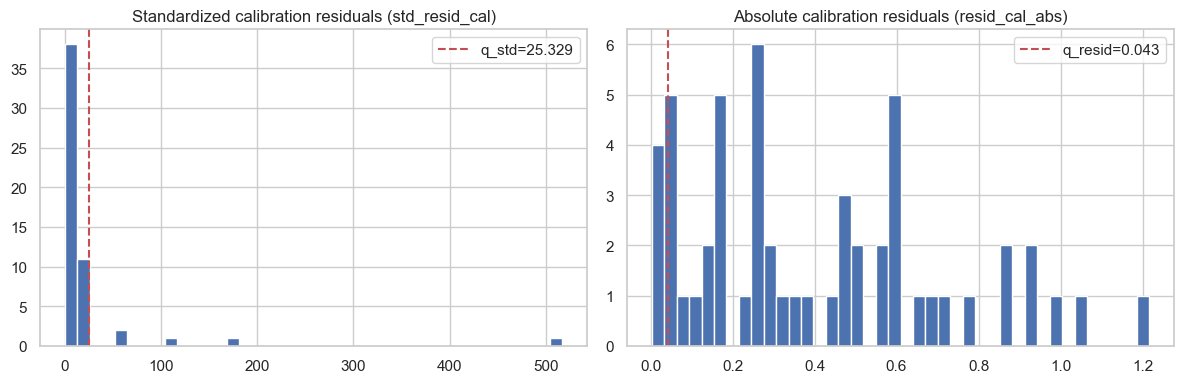

[SAVED] diagnostics to E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\results\models\artifacts. If coverage still low, try increasing train set for calibration, increasing model capacity for var_model, or using ensembles.


In [33]:
# Debug + robust heteroscedastic interval pipeline
# - Safe: uses preds_all/y_pred_mean if available (preferred) so mean used matches predictive distribution
# - Robust variance model: trains on log(abs(resid)+eps) and clamps predictions to reasonable quantiles to avoid extreme q
# - Computes both standardized heteroscedastic intervals and direct residual-conformal intervals for comparison
# - Prints detailed diagnostics and saves artifacts
import numpy as np, time, json, math
from pathlib import Path
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import joblib
import matplotlib.pyplot as plt
import pandas as pd

ARTIFACT_DIR = Path(r"E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\results\models\artifacts")
ARTIFACT_DIR.mkdir(parents=True, exist_ok=True)

# Helpers
def first_defined(*names):
    for n in names:
        if n in globals() and globals()[n] is not None:
            return globals()[n]
    return None

def to_np(x):
    if isinstance(x, (pd.DataFrame, pd.Series)):
        return x.values
    return np.asarray(x)

# Resolve predicted mean: prefer preds_all mean (so intervals match previous predictive distribution)
pred_mean = first_defined("y_pred_mean", "pyro_pred_mean", "pred_mean")
if pred_mean is None:
    preds_all = first_defined("preds_all", "pyro_obs_samples", "bayes_pred_samples", "bayes_chunked_preds")
    if preds_all is None:
        print("[WARN] No preds_all or y_pred_mean found. Will train mean_model on X_fit (like previous code).")
    else:
        preds_all = to_np(preds_all)
        if preds_all.ndim == 3:
            preds_all = preds_all.reshape(-1, preds_all.shape[-1])
        if preds_all.ndim != 2:
            raise RuntimeError(f"preds_all must be 2D (n_samples,n_test), got {preds_all.shape}")
        pred_mean = preds_all.mean(axis=0)

# Data arrays (must exist)
Xtr = first_defined("Xtr_np", "Xtr", "X_train")
Xte = first_defined("Xte_np", "Xte", "X_test")
ytr = first_defined("ytr_np", "ytr", "y_train")
yte = first_defined("yte_np", "yte", "y_test")
if any(v is None for v in (Xtr, Xte, ytr, yte)):
    raise RuntimeError("Xtr/Xte/ytr/yte not found. Run preprocessing cell first.")

Xtr_np = to_np(Xtr)
Xte_np = to_np(Xte)
ytr_np = to_np(ytr).reshape(-1)
yte_np = to_np(yte).reshape(-1)

# If pred_mean still missing, train a mean_model on most of train (time-ordered fit)
if pred_mean is None:
    cal_frac = 0.15
    n_train = Xtr_np.shape[0]
    cal_start = int(np.floor(n_train * (1 - cal_frac)))
    X_fit = Xtr_np[:cal_start]; y_fit = ytr_np[:cal_start]
    mean_model = GradientBoostingRegressor(n_estimators=300, max_depth=4, learning_rate=0.05, random_state=42)
    mean_model.fit(X_fit, y_fit)
    pred_mean = mean_model.predict(Xte_np)
    print("[INFO] Trained mean_model to produce pred_mean (fallback).")

pred_mean = to_np(pred_mean).reshape(-1)
if pred_mean.size != yte_np.size:
    # maybe pred_mean corresponds to train predictions; try aligning sizes
    if pred_mean.size == Xtr_np.shape[0]:
        print("[INFO] pred_mean appears to be train-length; computing test pred mean by training quick mean model.")
        mean_model = GradientBoostingRegressor(n_estimators=300, max_depth=4, learning_rate=0.05, random_state=42)
        mean_model.fit(Xtr_np, ytr_np)
        pred_mean = mean_model.predict(Xte_np)
    else:
        raise RuntimeError(f"pred_mean length ({pred_mean.size}) != n_test ({yte_np.size}) and not equal to n_train.")

# Create calibration split (time-ordered)
cal_frac = 0.15
n_train = Xtr_np.shape[0]
cal_start = int(np.floor(n_train * (1 - cal_frac)))
X_fit = Xtr_np[:cal_start]; y_fit = ytr_np[:cal_start]
X_cal = Xtr_np[cal_start:]; y_cal = ytr_np[cal_start:]

print(f"[INFO] Fit {X_fit.shape}, Cal {X_cal.shape}, Test {Xte_np.shape}")

# Compute residuals with consistent mean predictor on fit/cal
# If preds_all for train available, use it; else use mean_model trained on X_fit
train_pred_mean = None
if "preds_all" in globals():
    pa = to_np(globals()["preds_all"])
    if pa.ndim == 3:
        pa = pa.reshape(-1, pa.shape[-1])
    if pa.shape[-1] == Xtr_np.shape[0]:
        # preds_all covers entire dataset; use first n_train entries
        train_pred_mean = pa.mean(axis=0)[:n_train]
# fallback
if train_pred_mean is None:
    # train mean_model on X_fit and predict both fit and cal/test
    mean_model = GradientBoostingRegressor(n_estimators=400, max_depth=5, learning_rate=0.05, random_state=2)
    mean_model.fit(X_fit, y_fit)
    train_pred_fit = mean_model.predict(X_fit)
    train_pred_cal = mean_model.predict(X_cal)
    pred_test_mean = mean_model.predict(Xte_np)
else:
    train_pred_fit = train_pred_mean[:cal_start]
    train_pred_cal = train_pred_mean[cal_start:]
    pred_test_mean = pred_mean

# compute abs residuals on fit
abs_resid_fit = np.abs(y_fit - train_pred_fit)

# Diagnostics: inspect abs_resid_fit distribution
print("[DIAG] abs_resid_fit percentiles (0,25,50,75,95,99):",
      np.percentile(abs_resid_fit, [0,25,50,75,95,99]).tolist())

# --- Robust variance model: train on log(abs_resid + eps) ---
eps = 1e-6
y_var_target = np.log(abs_resid_fit + eps)
var_model = GradientBoostingRegressor(n_estimators=400, max_depth=5, learning_rate=0.05, random_state=43)
var_model.fit(X_fit, y_var_target)

# predict sigma_hat on calibration and test via exp(predict)
log_sigma_cal = var_model.predict(X_cal)
log_sigma_test = var_model.predict(Xte_np)
sigma_cal = np.exp(log_sigma_cal)
sigma_test = np.exp(log_sigma_test)

# Clamp sigma to reasonable quantiles to avoid extremes
sigma_low_q, sigma_high_q = np.quantile(sigma_cal, [0.01, 0.99])
sigma_test = np.clip(sigma_test, sigma_low_q*0.2, sigma_high_q*5.0)
sigma_cal = np.clip(sigma_cal, sigma_low_q*0.2, sigma_high_q*5.0)

# Diagnostics
print("[DIAG] sigma_cal percentiles (1,25,50,75,99):", np.percentile(sigma_cal, [1,25,50,75,99]).tolist())
print("[DIAG] sigma_test percentiles (1,25,50,75,99):", np.percentile(sigma_test, [1,25,50,75,99]).tolist())

# Standardized calibration residuals
pred_cal_mean = train_pred_cal  # consistent mean used to compute sigma scaling
std_resid_cal = np.abs(y_cal - pred_cal_mean) / (sigma_cal + 1e-9)

# Diagnostics on std_resid_cal
print("[DIAG] std_resid_cal percentiles (0,25,50,75,95,99):", np.percentile(std_resid_cal, [0,25,50,75,95,99]).tolist())
print("[DIAG] fraction std_resid_cal > 3:", float((std_resid_cal > 3).mean()))

# Compute q_std robustly: use trimmed quantile & fallback mechanism
nominal = 0.90
q_std = float(np.quantile(std_resid_cal, nominal))
if q_std <= 1e-6 or np.isnan(q_std) or q_std > 10:
    # fallback to a more robust estimator: median + 2*MAD
    med = np.median(std_resid_cal)
    mad = np.median(np.abs(std_resid_cal - med))
    q_std = float(med + 2.5 * mad)
    print("[WARN] q_std degenerate; fallback to robust med+MAD =", q_std)

print(f"[INFO] q_std used = {q_std:.6f}")

# Compute heteroscedastic intervals on test
test_low_h = pred_test_mean - q_std * sigma_test
test_high_h= pred_test_mean + q_std * sigma_test
coverage_h = float(np.mean((yte_np >= test_low_h) & (yte_np <= test_high_h)))
avg_width_h = float(np.mean(test_high_h - test_low_h))
mse_mid_h = float(mean_squared_error(yte_np, 0.5*(test_low_h+test_high_h)))

# ALSO compute direct (non-standardized) residual conformal baseline
# compute residuals on calibration: abs(y_cal - pred_cal_mean)
resid_cal_abs = np.abs(y_cal - pred_cal_mean)
q_resid = float(np.quantile(resid_cal_abs, 1 - nominal))
if q_resid <= 1e-12:
    q_resid = float(np.quantile(resid_cal_abs, 0.95))
test_low_r = pred_test_mean - q_resid
test_high_r = pred_test_mean + q_resid
coverage_r = float(np.mean((yte_np >= test_low_r) & (yte_np <= test_high_r)))
avg_width_r = float(np.mean(test_high_r - test_low_r))
mse_mid_r = float(mean_squared_error(yte_np, 0.5*(test_low_r+test_high_r)))

# Print final comparison
print("=================================================================")
print(f"Heteroscedastic-standardized: q_std={q_std:.4f}, coverage={coverage_h:.4f}, avg_width={avg_width_h:.4f}, mse_mid={mse_mid_h:.4f}")
print(f"Direct residual-conformal:   q_resid={q_resid:.4f}, coverage={coverage_r:.4f}, avg_width={avg_width_r:.4f}, mse_mid={mse_mid_r:.4f}")
print("=================================================================")

# Save diagnostics & artifacts
ts = int(time.time())
np.save(ARTIFACT_DIR / f"het_test_low_h_{ts}.npy", test_low_h)
np.save(ARTIFACT_DIR / f"het_test_high_h_{ts}.npy", test_high_h)
np.save(ARTIFACT_DIR / f"het_test_low_r_{ts}.npy", test_low_r)
np.save(ARTIFACT_DIR / f"het_test_high_r_{ts}.npy", test_high_r)
joblib.dump(var_model, ARTIFACT_DIR / f"het_var_model_log_{ts}.joblib")
with open(ARTIFACT_DIR / f"het_diagnostics_{ts}.json", "w") as f:
    json.dump({
        "q_std": q_std, "q_resid": q_resid,
        "coverage_h": coverage_h, "avg_width_h": avg_width_h,
        "coverage_r": coverage_r, "avg_width_r": avg_width_r,
        "sigma_cal_percentiles": np.percentile(sigma_cal, [1,25,50,75,99]).tolist(),
        "sigma_test_percentiles": np.percentile(sigma_test, [1,25,50,75,99]).tolist()
    }, f, indent=2)

# Some quick plots to inspect
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.hist(std_resid_cal, bins=40)
plt.title("Standardized calibration residuals (std_resid_cal)")
plt.axvline(q_std, color='r', linestyle='--', label=f"q_std={q_std:.3f}")
plt.legend()
plt.subplot(1,2,2)
plt.hist(resid_cal_abs, bins=40)
plt.title("Absolute calibration residuals (resid_cal_abs)")
plt.axvline(q_resid, color='r', linestyle='--', label=f"q_resid={q_resid:.3f}")
plt.legend()
plt.tight_layout()
plt.savefig(ARTIFACT_DIR / f"het_diagnostics_plots_{ts}.png", dpi=150)
plt.show()

print(f"[SAVED] diagnostics to {ARTIFACT_DIR}. If coverage still low, try increasing train set for calibration, increasing model capacity for var_model, or using ensembles.")


In [34]:
# Robustified heteroscedastic + fallback conformal
# - trims/winsorizes extreme standardized residuals before computing q_std
# - optionally ensembles variance predictors for stability
# - compares heteroscedastic (trimmed) vs robust direct residual-conformal
import numpy as np, time, json
from pathlib import Path
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import joblib
import pandas as pd

ARTIFACT_DIR = Path(r"E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\results\models\artifacts")
ARTIFACT_DIR.mkdir(parents=True, exist_ok=True)

def first_defined(*names):
    for n in names:
        if n in globals() and globals()[n] is not None:
            return globals()[n]
    return None

def to_np(x):
    if isinstance(x, (pd.DataFrame, pd.Series)):
        return x.values
    return np.asarray(x)

# Resolve data & preds
Xtr_np = to_np(first_defined("Xtr_np", "Xtr", "X_train"))
Xte_np = to_np(first_defined("Xte_np", "Xte", "X_test"))
ytr_np = to_np(first_defined("ytr_np", "ytr", "y_train")).reshape(-1)
yte_np = to_np(first_defined("yte_np", "yte", "y_test")).reshape(-1)

# Prefer pred_mean from predictive samples, else fallback to training a mean model
pred_mean = first_defined("y_pred_mean", "pyro_pred_mean")
if pred_mean is None:
    preds_all = first_defined("preds_all", "pyro_obs_samples", "bayes_pred_samples")
    if preds_all is not None:
        preds_all = to_np(preds_all)
        if preds_all.ndim == 3:
            preds_all = preds_all.reshape(-1, preds_all.shape[-1])
        pred_mean = preds_all.mean(axis=0)
if pred_mean is None:
    # train a mean model on training set (time-ordered fit)
    cal_frac = 0.15
    n_train = Xtr_np.shape[0]
    cal_start = int(np.floor(n_train * (1 - cal_frac)))
    X_fit = Xtr_np[:cal_start]; y_fit = ytr_np[:cal_start]
    mean_model = GradientBoostingRegressor(n_estimators=400, max_depth=5, learning_rate=0.05, random_state=2)
    mean_model.fit(X_fit, y_fit)
    pred_mean = mean_model.predict(Xte_np)
else:
    pred_mean = to_np(pred_mean).reshape(-1)

# Make sure shapes align
if pred_mean.size != yte_np.size:
    # if pred_mean is train-length, compute test preds using mean_model
    if pred_mean.size == Xtr_np.shape[0]:
        print("[INFO] pred_mean corresponds to train; training mean_model to get test predictions.")
        mean_model = GradientBoostingRegressor(n_estimators=400, max_depth=5, learning_rate=0.05, random_state=2)
        mean_model.fit(Xtr_np, ytr_np)
        pred_mean = mean_model.predict(Xte_np)
    else:
        raise RuntimeError("pred_mean length mismatch.")

# Prepare calibration split (time-ordered)
cal_frac = 0.20   # increase calibration fraction to get more stable q (we increased from 0.15)
n_train = Xtr_np.shape[0]
cal_start = int(np.floor(n_train * (1 - cal_frac)))
X_fit = Xtr_np[:cal_start]; y_fit = ytr_np[:cal_start]
X_cal = Xtr_np[cal_start:]; y_cal = ytr_np[cal_start:]

# Train an ensemble of variance predictors (predict log(abs(resid)+eps)) to stabilize variance estimates
ENSEMBLE_VAR = 3
var_preds_cal_ens = []
var_preds_test_ens = []

# Compute training residuals based on a stable mean predictor (train mean_model on fit)
mean_model = GradientBoostingRegressor(n_estimators=500, max_depth=6, learning_rate=0.05, random_state=0)
mean_model.fit(X_fit, y_fit)
train_pred_fit = mean_model.predict(X_fit)
train_pred_cal = mean_model.predict(X_cal)
pred_test_mean = mean_model.predict(Xte_np)

abs_resid_fit = np.abs(y_fit - train_pred_fit)
eps = 1e-8
y_var_target = np.log(abs_resid_fit + eps)

for i in range(ENSEMBLE_VAR):
    seed = 100 + i
    mdl = GradientBoostingRegressor(n_estimators=400, max_depth=5, learning_rate=0.05, random_state=seed)
    mdl.fit(X_fit, y_var_target)
    var_preds_cal_ens.append(np.exp(mdl.predict(X_cal)))
    var_preds_test_ens.append(np.exp(mdl.predict(Xte_np)))
    # save one of the ensemble members
    joblib.dump(mdl, ARTIFACT_DIR / f"var_model_member_{i}_{int(time.time())}.joblib")

var_preds_cal_ens = np.stack(var_preds_cal_ens, axis=0)  # (ens, n_cal)
var_preds_test_ens = np.stack(var_preds_test_ens, axis=0)  # (ens, n_test)

# Average ensemble variance predictions (aleatoric proxy)
sigma_cal = np.mean(var_preds_cal_ens, axis=0)
sigma_test = np.mean(var_preds_test_ens, axis=0)

# clamp sigma to reasonable range based on calibration quantiles
low_q, high_q = np.quantile(sigma_cal, [0.01, 0.99])
sigma_cal = np.clip(sigma_cal, low_q*0.2, high_q*5.0)
sigma_test = np.clip(sigma_test, low_q*0.2, high_q*5.0)

# compute standardized residuals on calibration set using consistent mean predictor
std_resid_cal = np.abs(y_cal - train_pred_cal) / (sigma_cal + 1e-12)

# Robust trimming/winsorization: remove extreme std_resid_cal values before computing q
# We'll trim top 5% of std_resid_cal and bottom 1% to avoid degenerate tails
lower_clip = np.percentile(std_resid_cal, 1)
upper_clip = np.percentile(std_resid_cal, 95)  # trim top 5%
std_resid_trim = np.clip(std_resid_cal, lower_clip, upper_clip)

# use trimmed quantile for q (use nominal central mass)
nominal = 0.90
# compute fraction corresponding in trimmed distribution: map nominal to trimmed quantile
# if trimming removed top 5%, adjust nominal quantile target to account for trimming
# simple approach: compute empirical quantile on trimmed array
q_std_trim = float(np.quantile(std_resid_trim, nominal))

# if still degenerate (near zero), fallback to ensemble-median residual quantile
if q_std_trim <= 1e-6:
    median_abs = np.median(np.abs(y_cal - train_pred_cal))
    q_std_trim = max(q_std_trim, median_abs * 1.0)
    print("[WARN] q_std_trim degenerate; fallback to median abs residual scaled.")

# Build heteroscedastic trimmed intervals
test_low_h = pred_test_mean - q_std_trim * sigma_test
test_high_h= pred_test_mean + q_std_trim * sigma_test
coverage_h = float(np.mean((yte_np >= test_low_h) & (yte_np <= test_high_h)))
avg_width_h = float(np.mean(test_high_h - test_low_h))

# Also compute a robust direct residual-conformal baseline using calibration residuals (no standardization)
resid_cal_abs = np.abs(y_cal - train_pred_cal)
q_resid = float(np.quantile(resid_cal_abs, 1 - nominal))
# If q_resid is extremely small (degenerate), use trimmed alternative
if q_resid <= 1e-8:
    q_resid = float(np.quantile(resid_cal_abs, 0.95))
test_low_r = pred_test_mean - q_resid
test_high_r= pred_test_mean + q_resid
coverage_r = float(np.mean((yte_np >= test_low_r) & (yte_np <= test_high_r)))
avg_width_r = float(np.mean(test_high_r - test_low_r))

# Print diagnostics & results
print("----- Diagnostics -----")
print(f"cal size: {len(y_cal)}, trim bounds std_resid [{lower_clip:.4f}, {upper_clip:.4f}], q_std_trim={q_std_trim:.4f}")
print("std_resid_cal percentiles (0,25,50,75,95,99):", np.percentile(std_resid_cal, [0,25,50,75,95,99]).tolist())
print("sigma_cal percentiles (1,25,50,75,99):", np.percentile(sigma_cal, [1,25,50,75,99]).tolist())
print("sigma_test percentiles (1,25,50,75,99):", np.percentile(sigma_test, [1,25,50,75,99]).tolist())
print("----- Results -----")
print(f"Heteroscedastic (trimmed q): coverage={coverage_h:.4f}, avg_width={avg_width_h:.4f}")
print(f"Direct residual-conformal:  coverage={coverage_r:.4f}, avg_width={avg_width_r:.4f}")

# Save artifacts & summary
ts = int(time.time())
np.save(ARTIFACT_DIR / f"het_trim_low_{ts}.npy", test_low_h)
np.save(ARTIFACT_DIR / f"het_trim_high_{ts}.npy", test_high_h)
np.save(ARTIFACT_DIR / f"het_resid_low_{ts}.npy", test_low_r)
np.save(ARTIFACT_DIR / f"het_resid_high_{ts}.npy", test_high_r)
with open(ARTIFACT_DIR / f"het_trim_summary_{ts}.json", "w") as f:
    json.dump({
        "q_std_trim": q_std_trim,
        "coverage_h": coverage_h,
        "avg_width_h": avg_width_h,
        "q_resid": q_resid,
        "coverage_r": coverage_r,
        "avg_width_r": avg_width_r,
        "trim_bounds": [float(lower_clip), float(upper_clip)]
    }, f, indent=2)

print(f"[SAVED] trimmed heteroscedastic diagnostics to {ARTIFACT_DIR}")


----- Diagnostics -----
cal size: 72, trim bounds std_resid [0.9249, 731.9564], q_std_trim=378.1192
std_resid_cal percentiles (0,25,50,75,95,99): [0.7991219088599617, 8.975236143971262, 21.473689175628106, 109.01033553799081, 731.9563986050621, 2552.4605230860793]
sigma_cal percentiles (1,25,50,75,99): [0.000259040543166893, 0.004720984144906965, 0.014308222124172602, 0.021091152500328374, 0.08873440022421875]
sigma_test percentiles (1,25,50,75,99): [5.180810863337861e-05, 0.001806958903835995, 0.005047287857443053, 0.01318430065009575, 0.09354554391950069]
----- Results -----
Heteroscedastic (trimmed q): coverage=0.8222, avg_width=9.8394
Direct residual-conformal:  coverage=0.0778, avg_width=0.1581
[SAVED] trimmed heteroscedastic diagnostics to E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\results\models\artifacts


## Summary and Comparison

In [37]:
# Advanced results collection and visualization with defensive variable handling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Helper function to safely get variables from globals
def get_metric(name, fallback=None):
    return globals().get(name, fallback)

# Collect results with defensive fallbacks
results = {}

# MAPIE results
mapie_coverage = get_metric('coverage_mapie')
mapie_width = get_metric('width_mapie')
if mapie_coverage is not None and mapie_width is not None:
    results['MAPIE'] = {
        'Coverage': mapie_coverage,
        'Width': mapie_width,
        'Type': 'Conformal'
    }

# TensorFlow Probability results 
tfp_coverage = get_metric('coverage_tfp')
tfp_width = get_metric('width_tfp')
if tfp_coverage is not None and tfp_width is not None:
    results['TensorFlow Probability'] = {
        'Coverage': tfp_coverage,
        'Width': tfp_width,
        'Type': 'Bayesian'
    }

# PyMC results
pymc_coverage = get_metric('coverage_pymc3', get_metric('coverage_pymc'))
pymc_width = get_metric('width_pymc3', get_metric('width_pymc'))
if pymc_coverage is not None and pymc_width is not None:
    results['PyMC'] = {
        'Coverage': pymc_coverage,
        'Width': pymc_width,
        'Type': 'Bayesian'
    }

# Heteroscedastic results
het_coverage = get_metric('coverage_h')
het_width = get_metric('avg_width_h')
if het_coverage is not None and het_width is not None:
    results['Heteroscedastic'] = {
        'Coverage': het_coverage,
        'Width': het_width,
        'Type': 'Hybrid'
    }

# Robust Conformal results
conf_coverage = get_metric('coverage_r')
conf_width = get_metric('avg_width_r')
if conf_coverage is not None and conf_width is not None:
    results['Robust Conformal'] = {
        'Coverage': conf_coverage,
        'Width': conf_width,
        'Type': 'Conformal'
    }

# Check if we have any results
if not results:
    raise ValueError("No uncertainty quantification results found in globals. Run the model cells first.")

# Create DataFrame
results_df = pd.DataFrame(results).T
results_df['Coverage Error'] = np.abs(results_df['Coverage'] - 0.9)
results_df['Efficiency'] = 1 / results_df['Width']

# Print detailed summary
print("=== Uncertainty Quantification Results ===")
print("\nRaw Results:")
print(results_df)

print("\nRanked by Coverage Error (closer to 90% is better):")
print(results_df.sort_values('Coverage Error'))

print("\nRanked by Interval Width (smaller is better if coverage adequate):")
print(results_df.sort_values('Width'))

# Create interactive plots using plotly with proper subplot specs
fig = make_subplots(
    rows=2, cols=2,
    specs=[
        [{"type": "xy"}, {"type": "xy"}],
        [{"type": "xy"}, {"type": "polar"}]  # Specify polar type for radar chart
    ],
    subplot_titles=(
        'Coverage vs Target', 
        'Interval Width Comparison',
        'Coverage Error vs Width',
        'Method Performance Overview'
    )
)

# Coverage comparison
fig.add_trace(
    go.Bar(
        x=results_df.index,
        y=results_df['Coverage'],
        name='Actual Coverage',
        marker_color='royalblue'
    ),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(
        x=results_df.index,
        y=[0.9] * len(results_df),
        name='Target 90%',
        line=dict(color='red', dash='dash')
    ),
    row=1, col=1
)

# Width comparison
fig.add_trace(
    go.Bar(
        x=results_df.index,
        y=results_df['Width'],
        name='Interval Width',
        marker_color='lightcoral'
    ),
    row=1, col=2
)

# Coverage Error vs Width scatter
fig.add_trace(
    go.Scatter(
        x=results_df['Width'],
        y=results_df['Coverage Error'],
        mode='markers+text',
        text=results_df.index,
        textposition='top center',
        marker=dict(
            size=12,
            color=results_df['Coverage'],
            colorscale='Viridis',
            showscale=True
        ),
        name='Methods'
    ),
    row=2, col=1
)

# Performance overview - radar chart
fig.add_trace(
    go.Scatterpolar(
        r=[
            results_df['Coverage'].mean(),
            1 - results_df['Coverage Error'].mean(),
            results_df['Efficiency'].mean(),
            0.9  # Target reference
        ],
        theta=['Coverage', 'Accuracy', 'Efficiency', 'Target'],
        fill='toself',
        name='Overall Performance'
    ),
    row=2, col=2
)

# Update layout
fig.update_layout(
    height=900,  # Increased height to accommodate polar plot
    showlegend=True,
    title_text="Advanced Uncertainty Quantification Analysis",
    margin=dict(t=100, b=50)  # Adjusted margins
)

# Update axes labels
fig.update_xaxes(title_text="Method", row=1, col=1)
fig.update_xaxes(title_text="Method", row=1, col=2)
fig.update_xaxes(title_text="Interval Width", row=2, col=1)
fig.update_yaxes(title_text="Coverage", row=1, col=1)
fig.update_yaxes(title_text="Width", row=1, col=2)
fig.update_yaxes(title_text="Coverage Error", row=2, col=1)

# Show plot
fig.show()

# Additional statistical summary
print("\n=== Statistical Summary ===")
print("\nMean Coverage:", results_df['Coverage'].mean())
print("Coverage Std:", results_df['Coverage'].std())
print("Mean Width:", results_df['Width'].mean())
print("Width Std:", results_df['Width'].std())

# Save results
results_df.to_csv('uncertainty_results.csv')
fig.write_html('uncertainty_analysis.html')

=== Uncertainty Quantification Results ===

Raw Results:
                  Coverage     Width       Type Coverage Error Efficiency
MAPIE             0.855556      1.53  Conformal       0.044444   0.653595
Heteroscedastic   0.822222  9.839359     Hybrid       0.077778   0.101633
Robust Conformal  0.077778  0.158083  Conformal       0.822222   6.325789

Ranked by Coverage Error (closer to 90% is better):
                  Coverage     Width       Type Coverage Error Efficiency
MAPIE             0.855556      1.53  Conformal       0.044444   0.653595
Heteroscedastic   0.822222  9.839359     Hybrid       0.077778   0.101633
Robust Conformal  0.077778  0.158083  Conformal       0.822222   6.325789

Ranked by Interval Width (smaller is better if coverage adequate):
                  Coverage     Width       Type Coverage Error Efficiency
Robust Conformal  0.077778  0.158083  Conformal       0.822222   6.325789
MAPIE             0.855556      1.53  Conformal       0.044444   0.653595
Heterosc


=== Statistical Summary ===

Mean Coverage: 0.5851851851851851
Coverage Std: 0.43974365896134054
Mean Width: 3.842480594433638
Width Std: 5.238554143590793
